In [1]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

from einops import rearrange
from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from case_studies.dc2_mdt.utils.encoder import DiffusionEncoder

In [2]:
model_tag_name = "mdt"
model_name = "exp_04-12-1"
model_check_point_name = "encoder_152.ckpt"
model_path = f"../../../bliss_output/DC2_mdt_exp/{model_name}/checkpoints/{model_check_point_name}"
cached_data_path = Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:7")
with initialize(config_path="./mdt_config", version_base=None):
    cfg = compose("mdt_train_config")
infer_batch_size = 720

In [3]:
seed = cfg.train.seed
print(f"using seed {seed}")
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


using seed 7272


7272

In [4]:
dc2: DC2DataModule = instantiate(cfg.surveys.dc2)
dc2.batch_size = infer_batch_size
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

diffusion_encoder: DiffusionEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
diffusion_encoder.load_state_dict(pretrained_weights)
diffusion_encoder.eval();

In [5]:
diffusion_encoder.reconfig_sampling(new_sampling_time_steps=50, new_ddim_eta=0.0)

In [6]:
max_fluxes = diffusion_encoder.max_fluxes
print(f"max_fluxes: {max_fluxes}")

max_fluxes: 22025.0


In [7]:
diffusion_cached_file_name = f"{model_tag_name}_" \
                             f"posterior_{model_name}_{model_check_point_name}_whole_val_set_" \
                             f"seed_{seed}.pt"
save_path = cached_data_path / diffusion_cached_file_name

if not os.path.isfile(save_path):
    print(f"can't find cached file [{diffusion_cached_file_name}]; rerun the inference")

    diffusion_result_dict = {
        "pred_n_sources_list": [],
        "pred_locs_list": [],
        "pred_fluxes_list": [],
        "target_n_sources_list": [],
        "target_locs_list": [],
        "target_fluxes_list": [],
    }

    for one_batch in tqdm.tqdm(dc2_val_dataloader):
        one_batch = move_data_to_device(one_batch, device=device)

        target_tile_cat = TileCatalog(one_batch["tile_catalog"])
        diffusion_result_dict["target_n_sources_list"].append(target_tile_cat["n_sources"].cpu())
        target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2)
        diffusion_result_dict["target_locs_list"].append(target_tile_cat["locs"].cpu())
        diffusion_result_dict["target_fluxes_list"].append(target_tile_cat["fluxes"].clamp(max=max_fluxes).cpu())

        with torch.inference_mode():
            sample_tile_cat = diffusion_encoder.sample(one_batch)

        diffusion_result_dict["pred_n_sources_list"].append(sample_tile_cat["n_sources"].cpu())
        diffusion_result_dict["pred_locs_list"].append(sample_tile_cat["locs"][..., 0:1, :].cpu())  # (b, h, w, 1, 2)
        diffusion_result_dict["pred_fluxes_list"].append(sample_tile_cat["fluxes"][..., 0:1, :].cpu())  # (b, h, w, 1, 6)

    torch.save(diffusion_result_dict, save_path)
else:
    print(f"find the cached file [{diffusion_cached_file_name}]; directly load it")
    with open(save_path, "rb") as f:
        diffusion_result_dict = torch.load(f, map_location="cpu")

find the cached file [mdt_posterior_exp_04-12-1_encoder_152.ckpt_whole_val_set_seed_7272.pt]; directly load it


In [8]:
for k, v in diffusion_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([720, 20, 20])
pred_locs_list[0]: torch.Size([720, 20, 20, 1, 2])
pred_fluxes_list[0]: torch.Size([720, 20, 20, 1, 6])
target_n_sources_list[0]: torch.Size([720, 20, 20])
target_locs_list[0]: torch.Size([720, 20, 20, 1, 2])
target_fluxes_list[0]: torch.Size([720, 20, 20, 1, 6])


In [9]:
with open(cached_data_path / "bliss_posterior_exp_03-30-1_encoder_44.ckpt_whole_val_set_seed_7272.pt", "rb") as f:
    bliss_result_dict = torch.load(f, map_location="cpu")

In [10]:
for k, v in bliss_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 1, 6])
target_n_sources_list[0]: torch.Size([800, 20, 20])
target_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target_fluxes_list[0]: torch.Size([800, 20, 20, 1, 6])


## Flux Scatter

In [11]:
diffusion_true_fluxes = {
    band: [] for band in "ugrizy"
}
diffusion_pred_fluxes = {
    band: [] for band in "ugrizy"
}
for pred_ns, true_ns, pred_f, true_f in zip(diffusion_result_dict["pred_n_sources_list"], 
                                            diffusion_result_dict["target_n_sources_list"],
                                            diffusion_result_dict["pred_fluxes_list"], 
                                            diffusion_result_dict["target_fluxes_list"],
                                            strict=True):
    ns_mask = (pred_ns > 0) & (true_ns > 0)
    for band, pred_bf in zip("ugrizy", pred_f[ns_mask][:, 0, :].T):
        diffusion_pred_fluxes[band].append(pred_bf)
    for band, true_bf in zip("ugrizy", true_f[ns_mask][:, 0, :].T):
        diffusion_true_fluxes[band].append(true_bf)

for k, v in diffusion_true_fluxes.items():
    diffusion_true_fluxes[k] = torch.cat(v, dim=0)
for k, v in diffusion_pred_fluxes.items():
    diffusion_pred_fluxes[k] = torch.cat(v, dim=0)

In [12]:
for k, v in diffusion_true_fluxes.items():
    v_m = convert_flux_to_magnitude(v, zero_point=3631e9)
    print(f"{k}: min {v_m.min().item():.3f}, max {v_m.max().item():.3f}")

u: min 20.543, max 31.469
g: min 20.543, max 28.744
r: min 20.543, max 26.400
i: min 20.543, max 26.883
z: min 20.543, max 26.916
y: min 20.543, max 26.772


In [38]:
def symmetry_deviation_wrt_45d(points: torch.Tensor, sample_n=1000, iters=100):
    min_dists_list = []
    for _ in range(iters):
        sub_points = points[torch.randperm(points.shape[0])[:sample_n], :]
        reflected_points = sub_points[:, [1, 0]]
        diff = reflected_points[:, None, :] - sub_points[None, :, :]
        dists = torch.norm(diff, dim=-1)  # (N, N)
        min_dists = dists.amin(dim=1)  # (N,)
        min_dists_list.append(min_dists.median())
    return torch.stack(min_dists_list, dim=0).median().item()

In [45]:
mag_bin_boundaries = {
    "u": torch.tensor([21.0428, 23.5071, 25.9714, 28.4357, 30.9001]),
    "g": torch.tensor([21.0428, 22.8431, 24.6434, 26.4437, 28.2440]),
    "r": torch.tensor([21.0428, 22.2571, 23.4714, 24.6857, 25.9001]),
    "i": torch.tensor([21.0428, 22.3778, 23.7127, 25.0477, 26.3827]),
    "z": torch.tensor([21.0428, 22.3861, 23.7295, 25.0728, 26.4162]),
    "y": torch.tensor([21.0428, 22.3502, 23.6575, 24.9649, 26.2723]),
}

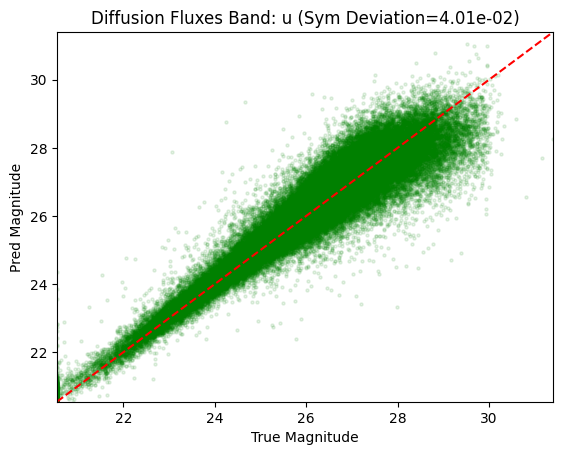

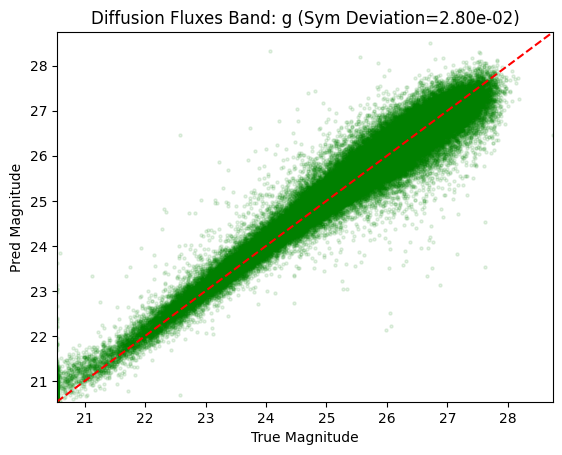

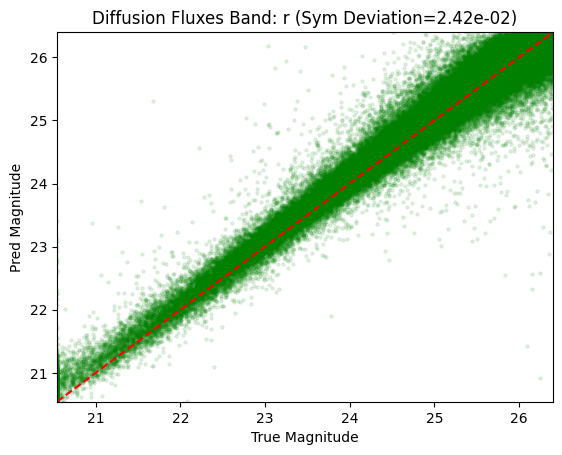

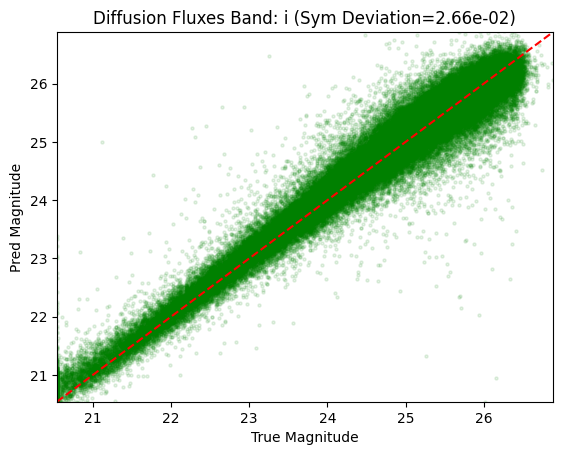

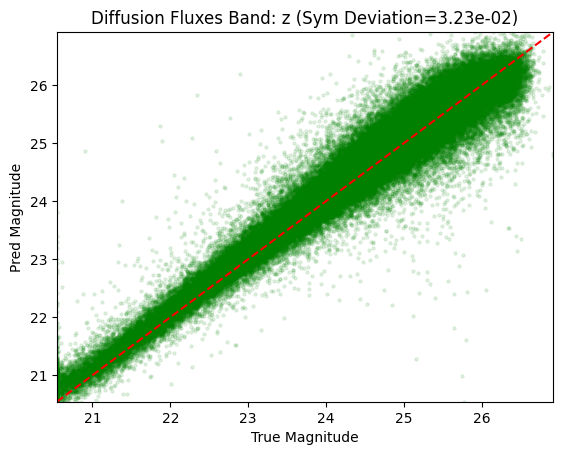

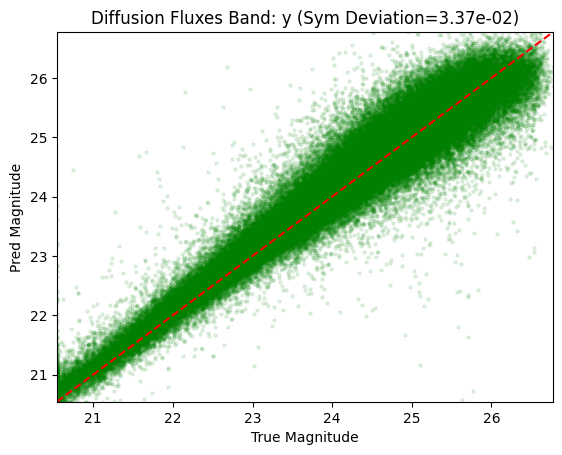

In [46]:
for band in "ugrizy":
    d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    band_mag_mask = (d_pred_m > mag_bin_boundaries[band].min()) & \
                    (d_pred_m < mag_bin_boundaries[band].max()) & \
                    (d_true_m > mag_bin_boundaries[band].min()) & \
                    (d_true_m < mag_bin_boundaries[band].max())
    sym_dev = symmetry_deviation_wrt_45d(torch.stack([d_pred_m, d_true_m], dim=1)[band_mag_mask])
    plt.scatter(d_true_m, d_pred_m, 
                s=5, c="green", alpha=0.1)
    expect_pts = torch.linspace(d_true_m.min(), d_true_m.max(), 10)
    plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
    plt.xlim(d_true_m.min(), d_true_m.max())
    plt.ylim(d_true_m.min(), d_true_m.max())
    plt.xlabel("True Magnitude")
    plt.ylabel("Pred Magnitude")
    plt.title(f"Diffusion Fluxes Band: {band} (Sym Deviation={sym_dev:.2e})")
    plt.show()

In [14]:
bliss_true_fluxes = {
    band: [] for band in "ugrizy"
}
bliss_pred_fluxes = {
    band: [] for band in "ugrizy"
}
for pred_ns, true_ns, pred_f, true_f in zip(bliss_result_dict["pred_n_sources_list"], 
                                            bliss_result_dict["target_n_sources_list"],
                                            bliss_result_dict["pred_fluxes_list"], 
                                            bliss_result_dict["target_fluxes_list"],
                                            strict=True):
    ns_mask = (pred_ns > 0) & (true_ns > 0)
    for band, pred_bf in zip("ugrizy", pred_f[ns_mask][:, 0, :].T):
        bliss_pred_fluxes[band].append(pred_bf)
    for band, true_bf in zip("ugrizy", true_f[ns_mask][:, 0, :].T):
        bliss_true_fluxes[band].append(true_bf)

for k, v in bliss_true_fluxes.items():
    bliss_true_fluxes[k] = torch.cat(v, dim=0)
for k, v in bliss_pred_fluxes.items():
    bliss_pred_fluxes[k] = torch.cat(v, dim=0)

In [15]:
for k, v in bliss_true_fluxes.items():
    v_m = convert_flux_to_magnitude(v, zero_point=3631e9)
    print(f"{k}: min {v_m.min().item():.3f}, max {v_m.max().item():.3f}")

u: min 12.563, max 31.469
g: min 11.428, max 28.744
r: min 10.832, max 26.400
i: min 10.590, max 26.891
z: min 10.489, max 26.916
y: min 10.440, max 27.021


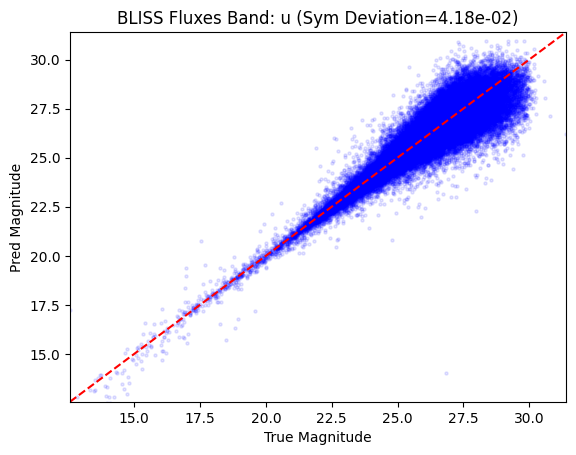

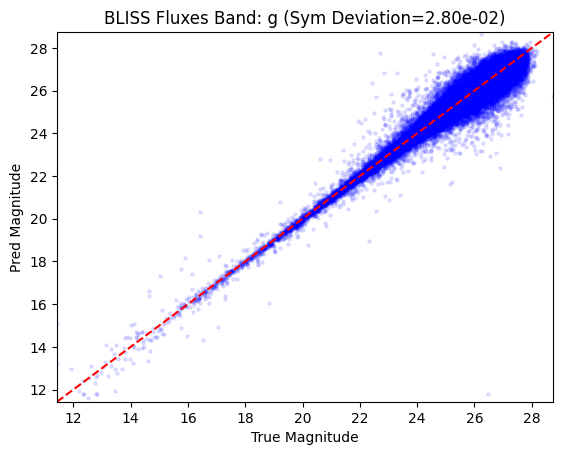

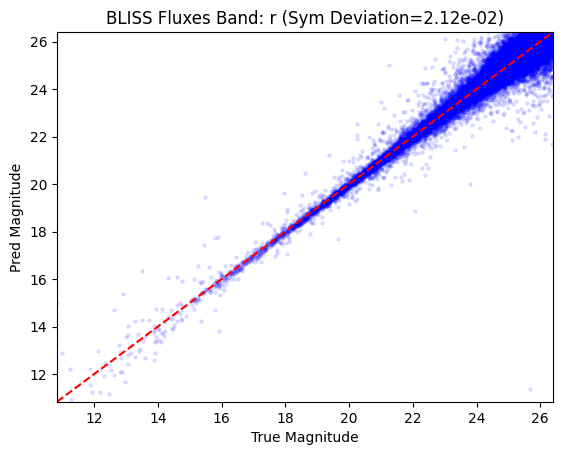

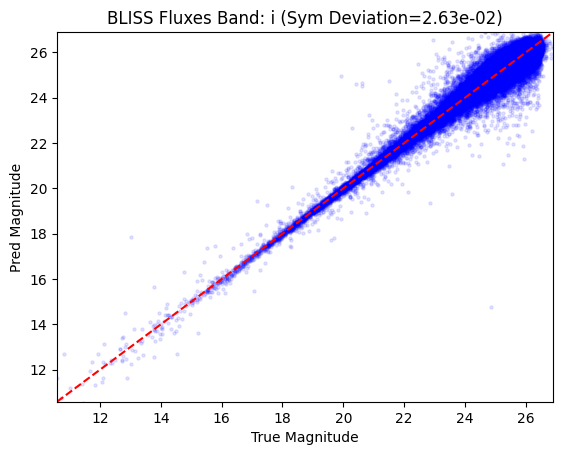

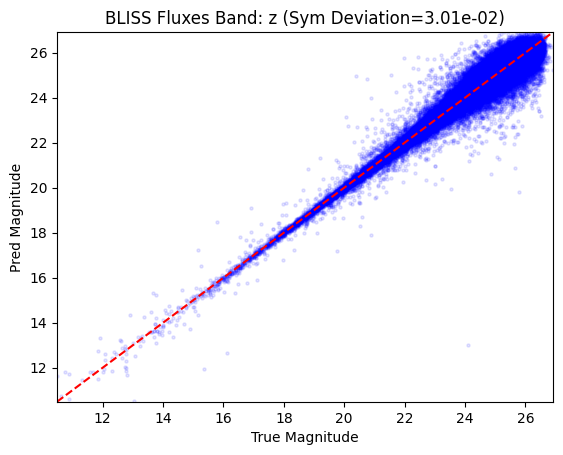

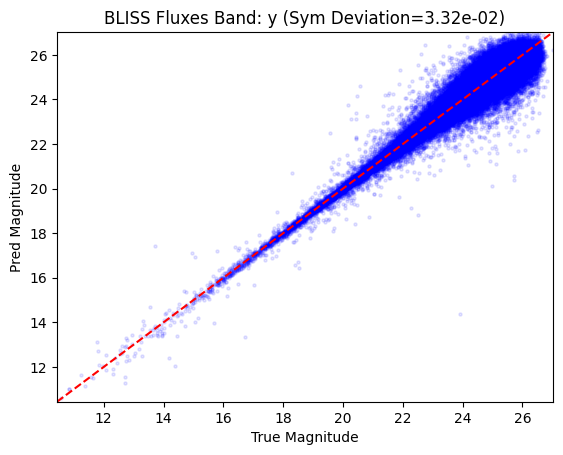

In [47]:
for band in "ugrizy":
    b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_true_m = convert_flux_to_magnitude(bliss_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    band_mag_mask = (b_pred_m > mag_bin_boundaries[band].min()) & \
                    (b_pred_m < mag_bin_boundaries[band].max()) & \
                    (b_true_m > mag_bin_boundaries[band].min()) & \
                    (b_true_m < mag_bin_boundaries[band].max())
    sym_dev = symmetry_deviation_wrt_45d(torch.stack([b_pred_m, b_true_m], dim=1)[band_mag_mask])
    plt.scatter(b_true_m, b_pred_m, 
                s=5, c="blue", alpha=0.1)
    expect_pts = torch.linspace(b_true_m.min(), b_true_m.max(), 10)
    plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
    plt.xlim(b_true_m.min(), b_true_m.max())
    plt.ylim(b_true_m.min(), b_true_m.max())
    plt.xlabel("True Magnitude")
    plt.ylabel("Pred Magnitude")
    plt.title(f"BLISS Fluxes Band: {band} (Sym Deviation={sym_dev:.2e})")
    plt.show()

## Flux

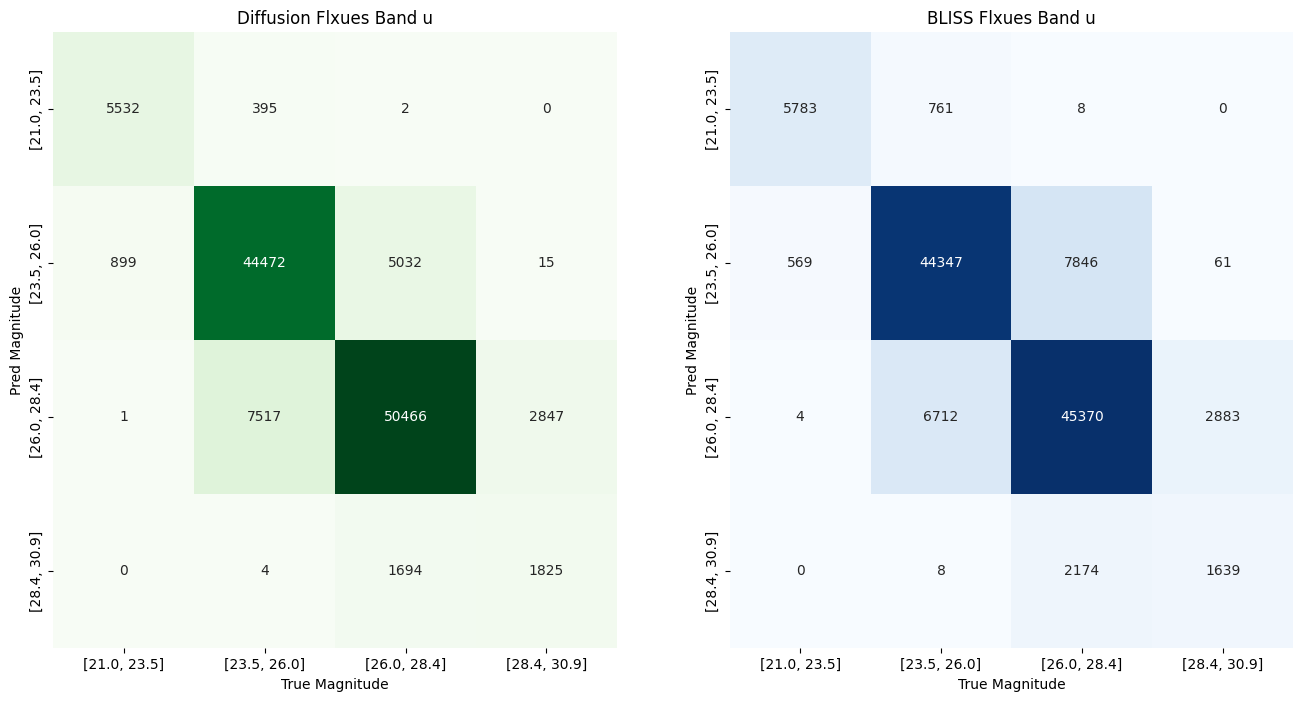

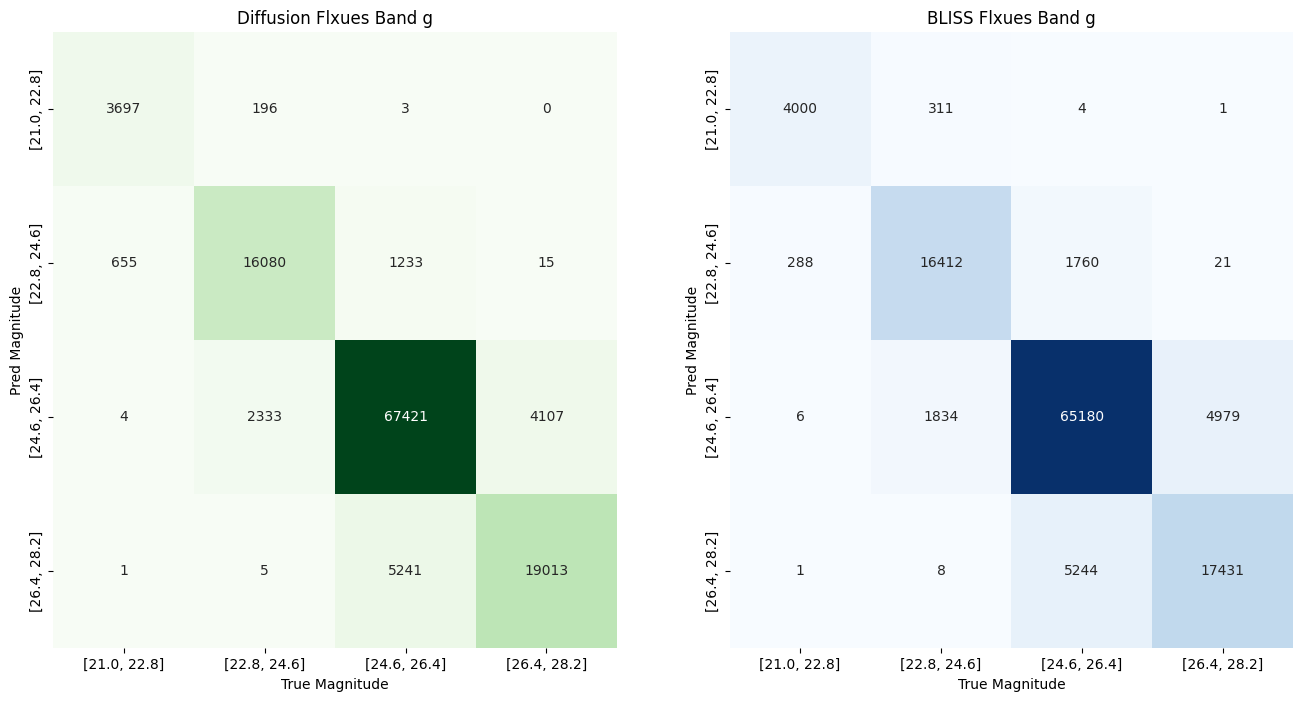

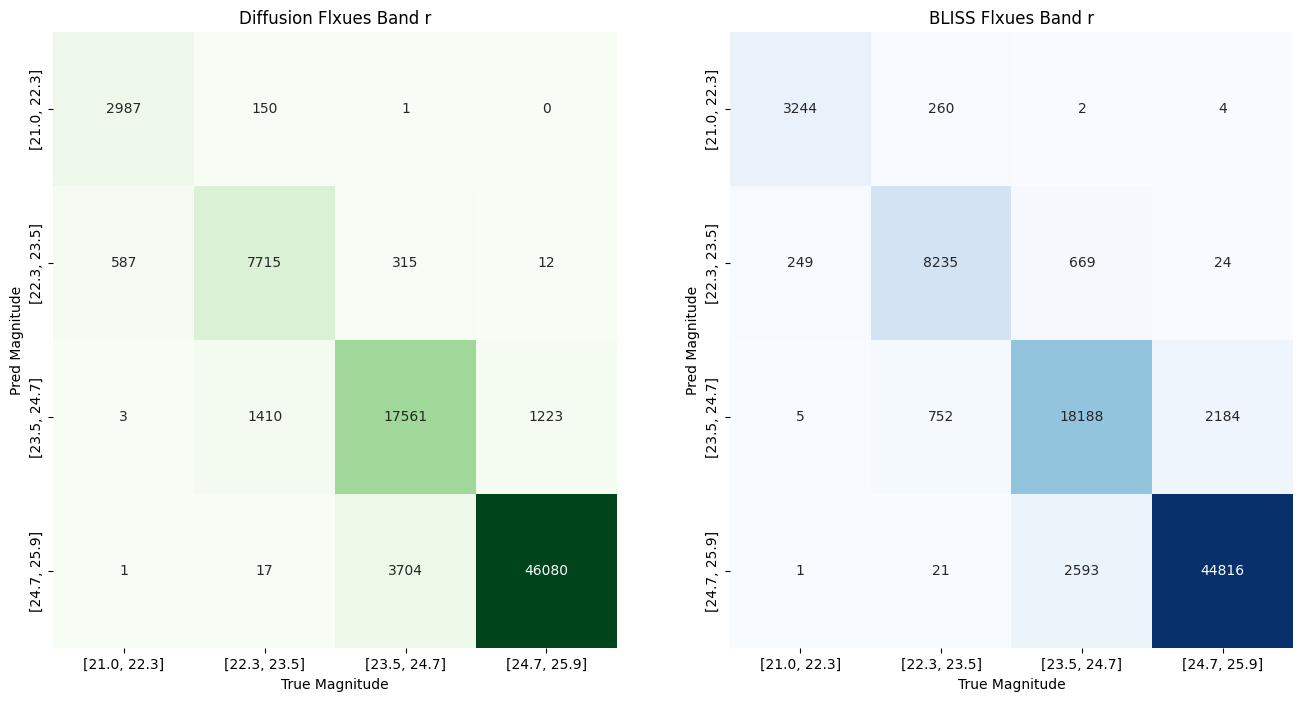

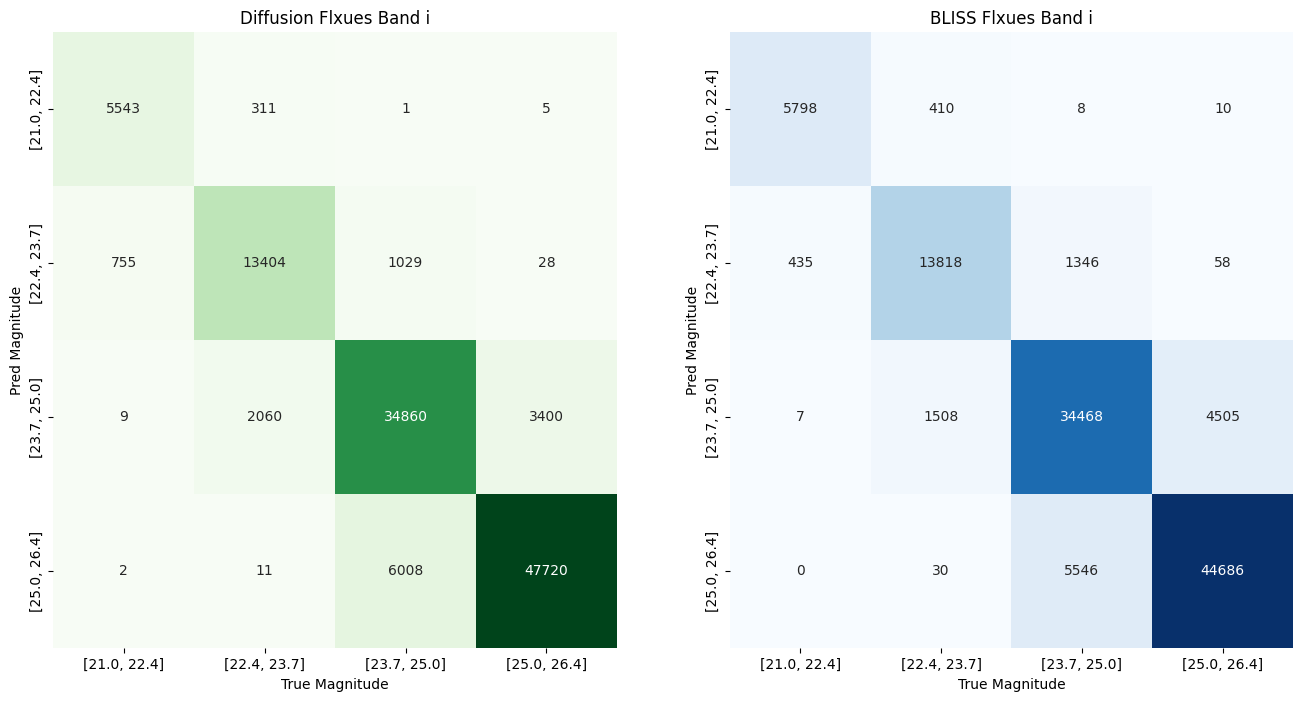

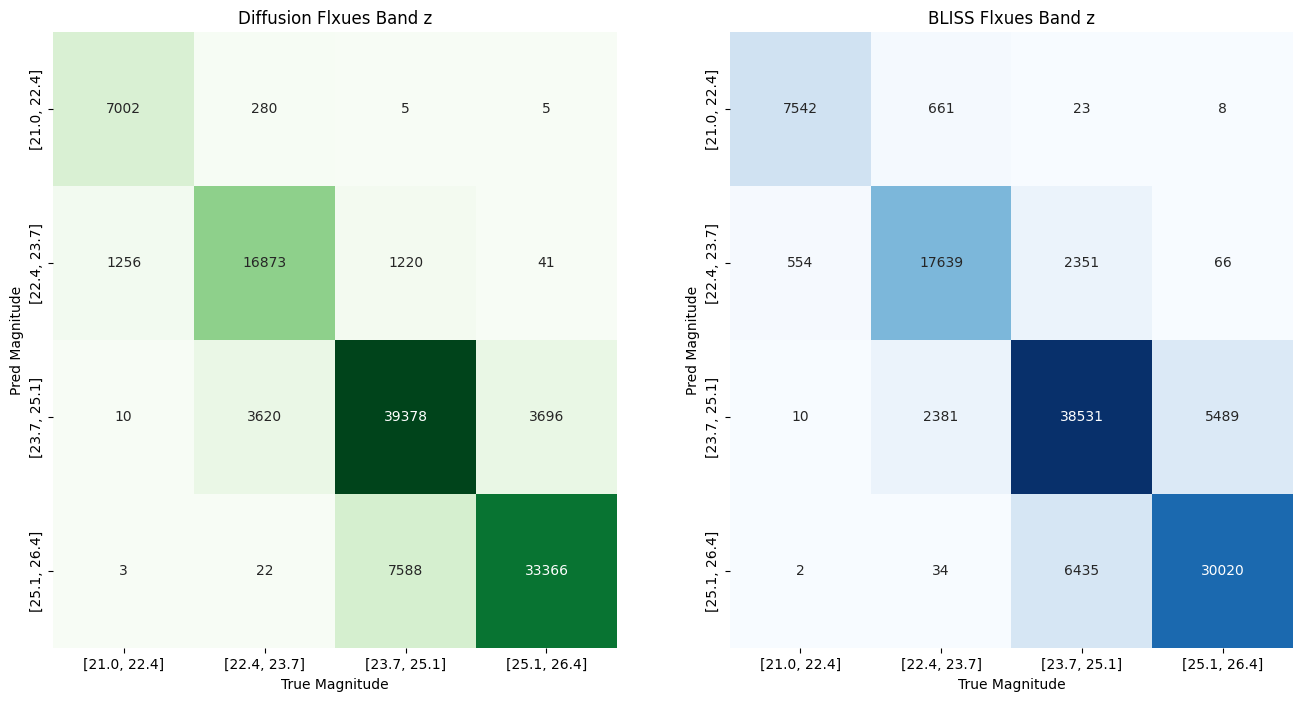

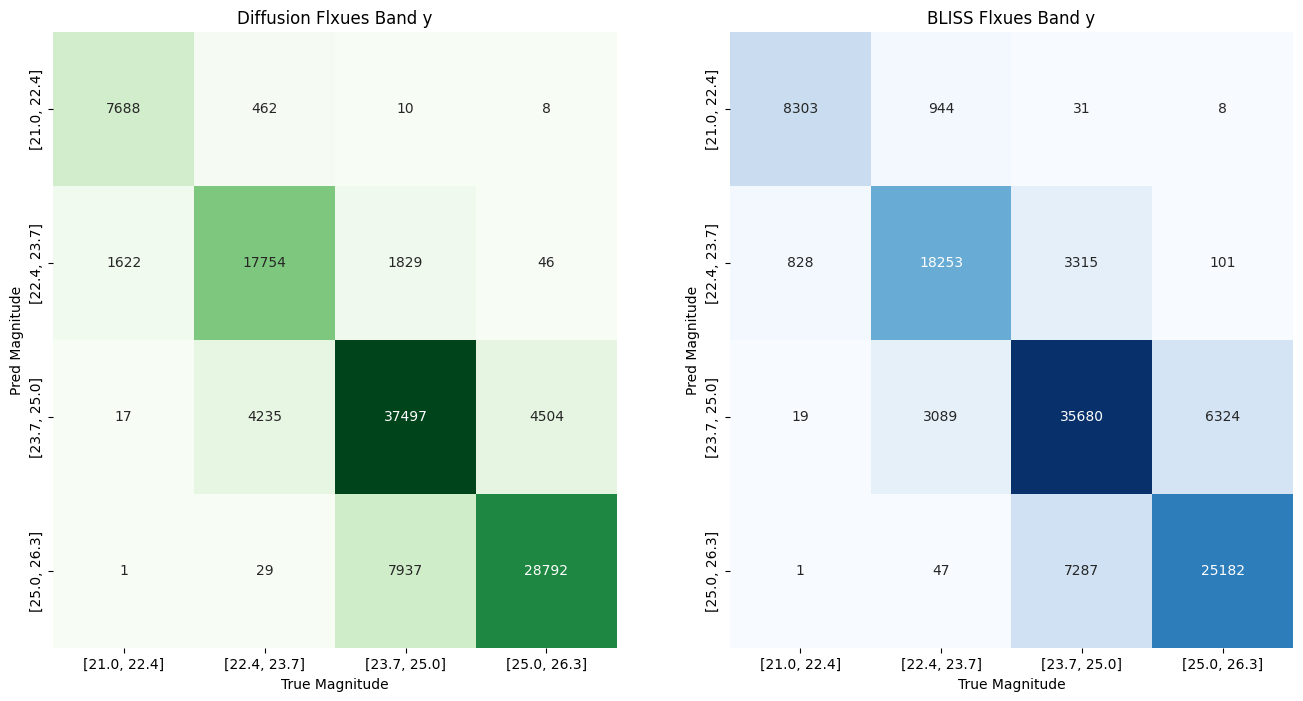

In [17]:
for band in "ugrizy":
    d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_true_m = convert_flux_to_magnitude(bliss_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)

    min_m = max(d_true_m.min().item(), b_true_m.min().item()) + 0.5
    max_m = min(d_true_m.max().item(), b_true_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_pred_m_bin_indexes = torch.bucketize(d_pred_m, bin_boundaries)
    d_true_m_bin_indexes = torch.bucketize(d_true_m, bin_boundaries)
    b_pred_m_bin_indexes = torch.bucketize(b_pred_m, bin_boundaries)
    b_true_m_bin_indexes = torch.bucketize(b_true_m, bin_boundaries)
    
    d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(d_pred_m_bin_indexes, d_true_m_bin_indexes, strict=True):
        d_cm[pred_i, true_i] += 1
    d_cm = d_cm[1:-1, 1:-1]
    b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(b_pred_m_bin_indexes, b_true_m_bin_indexes, strict=True):
        b_cm[pred_i, true_i] += 1
    b_cm = b_cm[1:-1, 1:-1]

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel("True Magnitude")
    axes[0].set_ylabel("Pred Magnitude")
    axes[0].set_title(f"Diffusion Flxues Band {band}")
    sns.heatmap(b_cm,
                annot=True,
                fmt="d", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel("True Magnitude")
    axes[1].set_ylabel("Pred Magnitude")
    axes[1].set_title(f"BLISS Flxues Band {band}")
    fig.show()

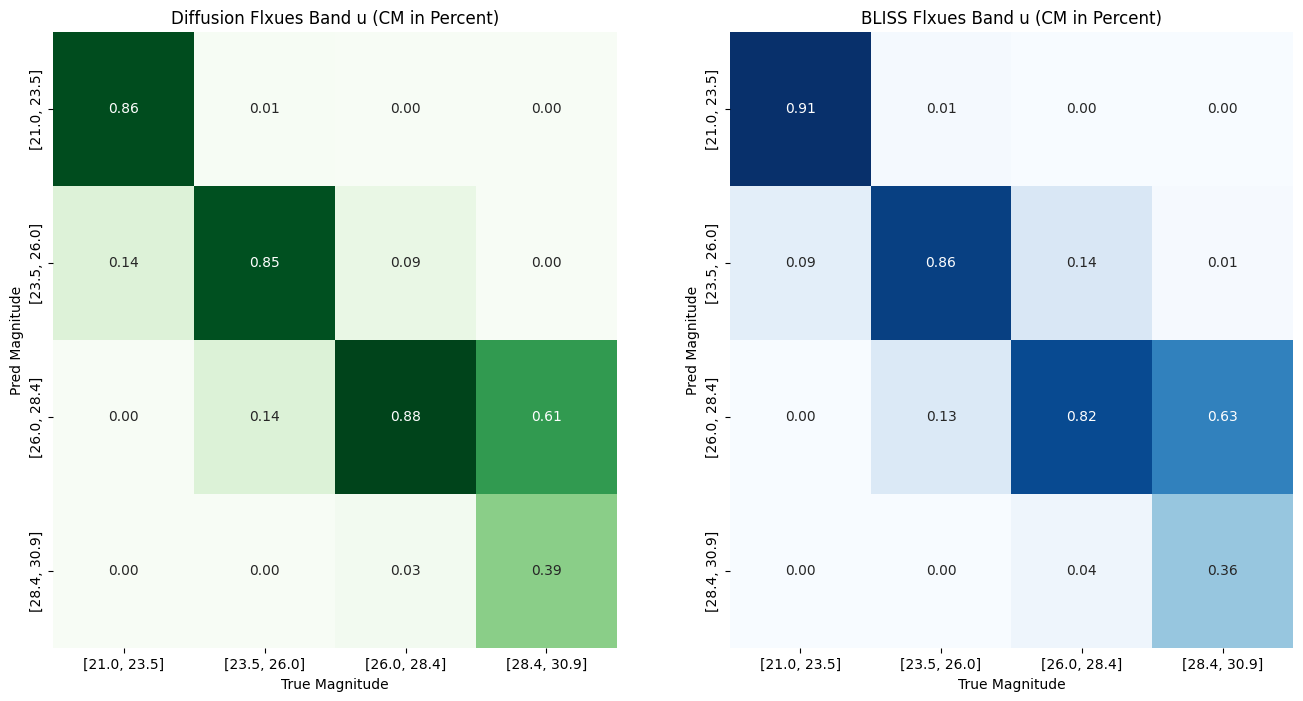

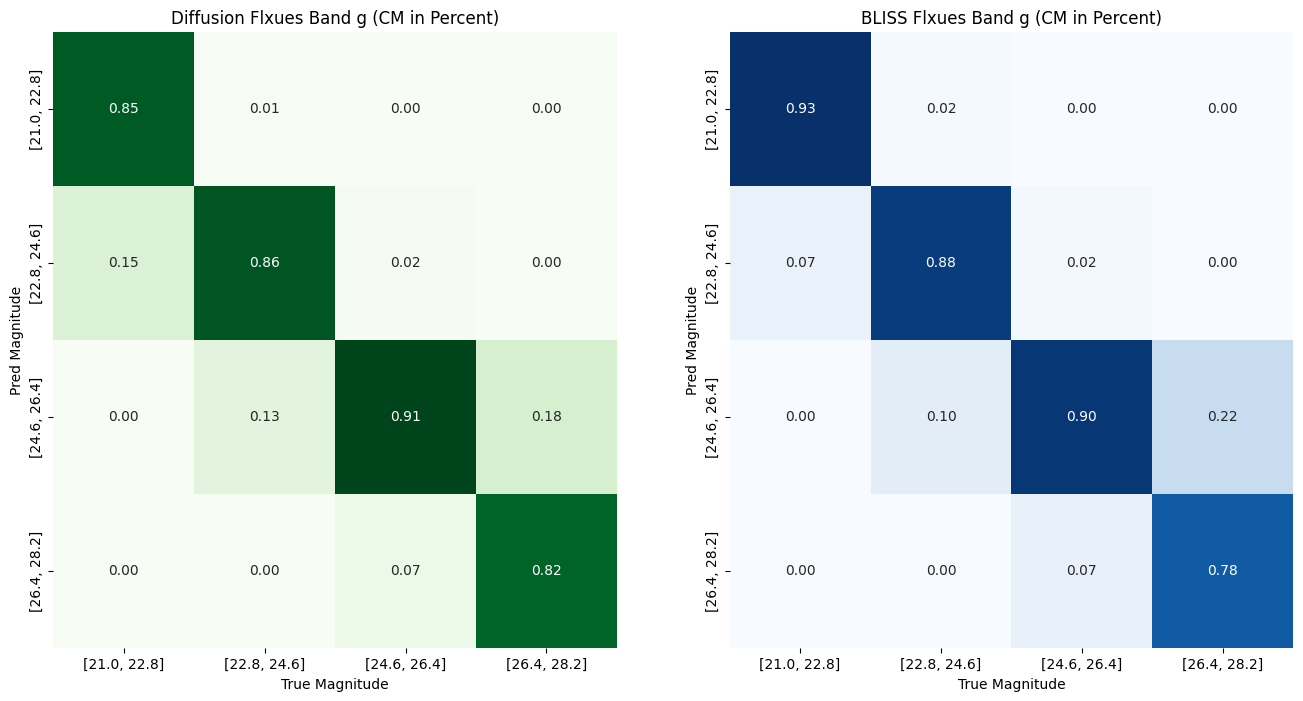

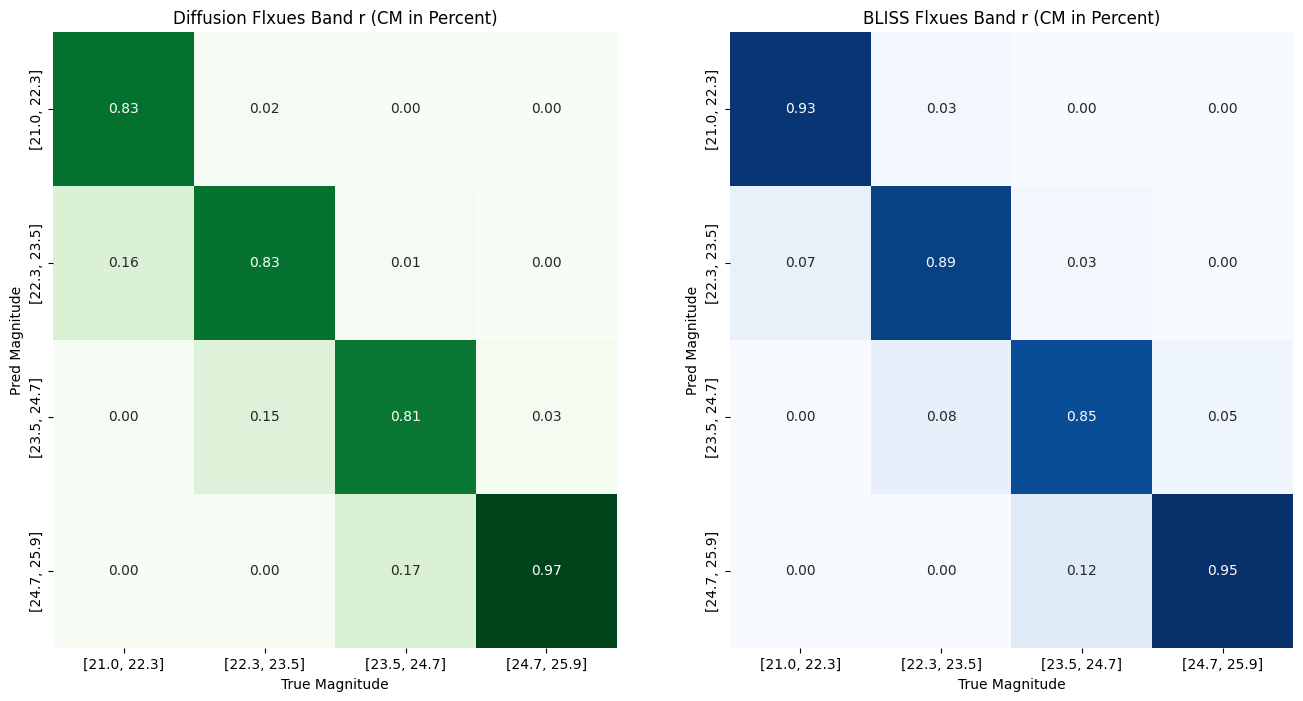

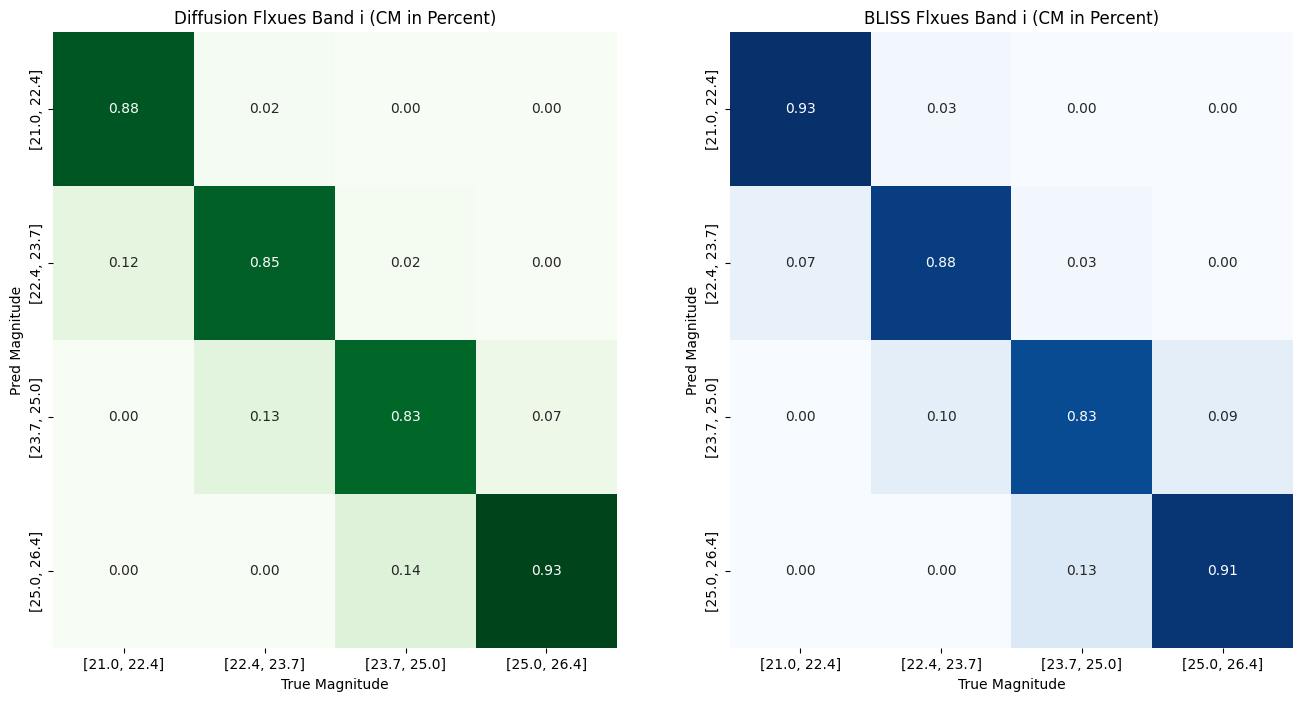

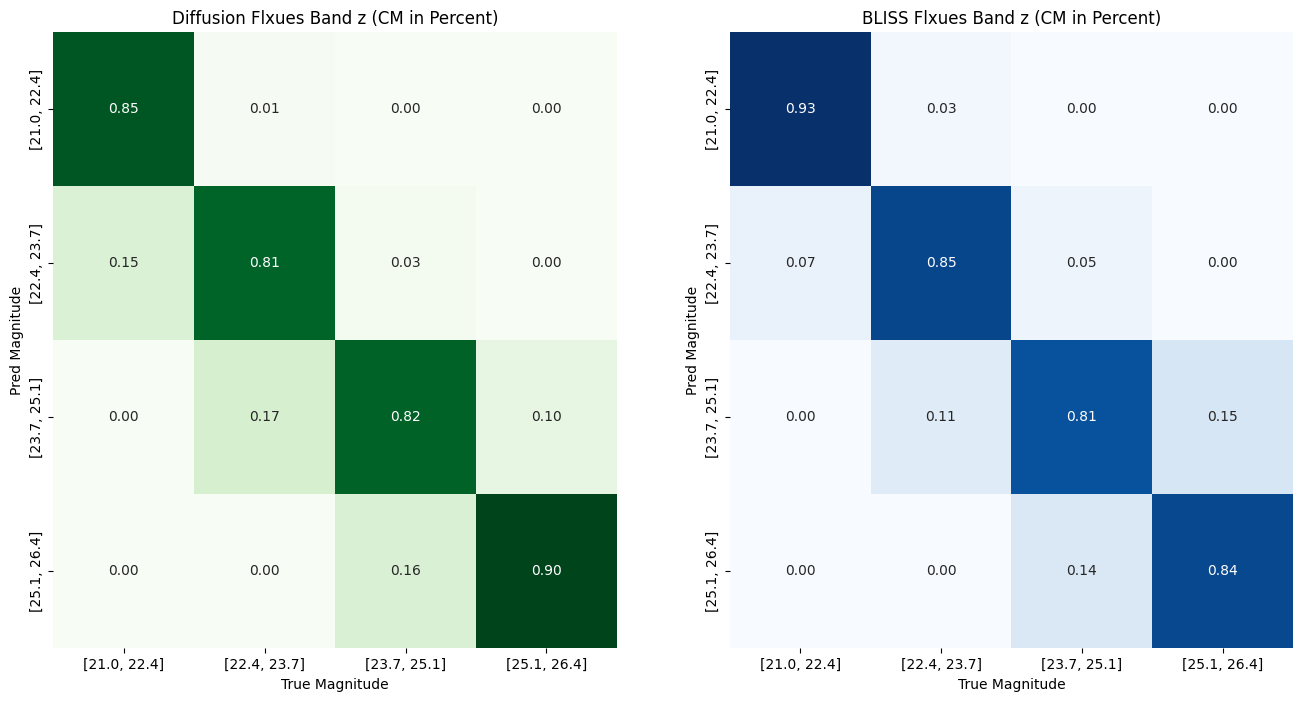

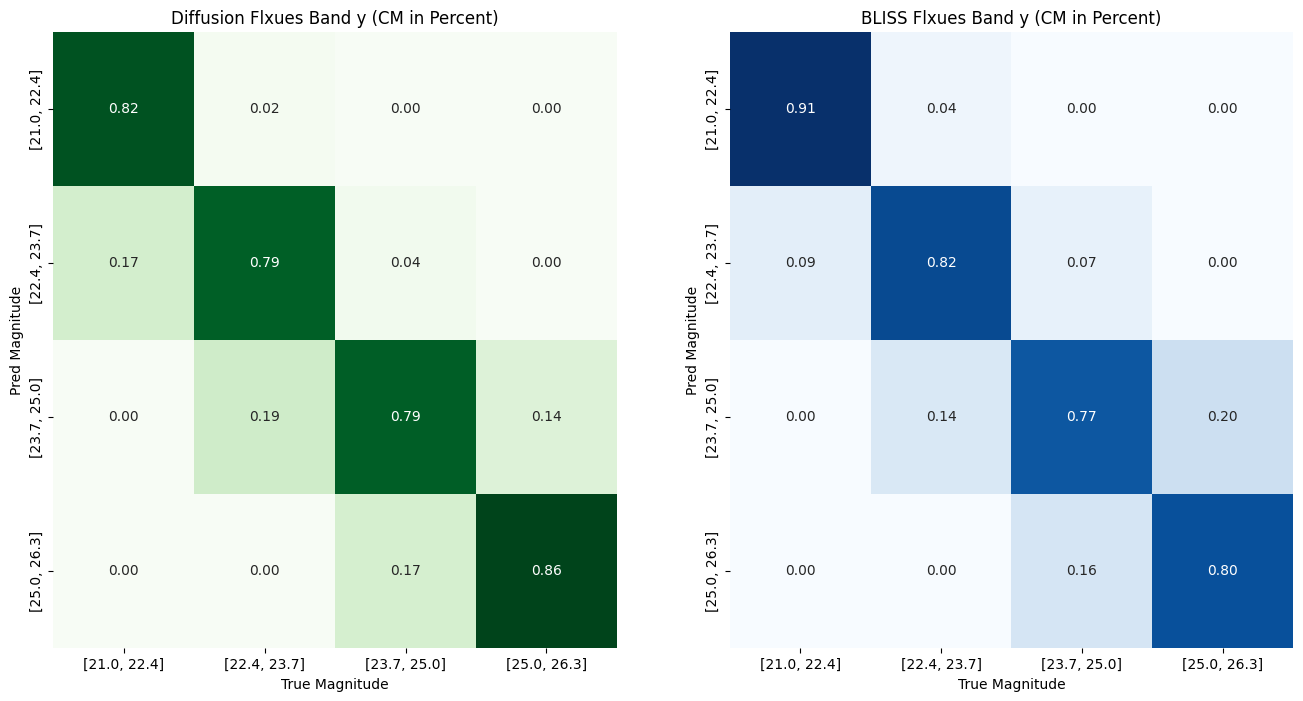

In [18]:
for band in "ugrizy":
    d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_true_m = convert_flux_to_magnitude(bliss_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)

    min_m = max(d_true_m.min().item(), b_true_m.min().item()) + 0.5
    max_m = min(d_true_m.max().item(), b_true_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_pred_m_bin_indexes = torch.bucketize(d_pred_m, bin_boundaries)
    d_true_m_bin_indexes = torch.bucketize(d_true_m, bin_boundaries)
    b_pred_m_bin_indexes = torch.bucketize(b_pred_m, bin_boundaries)
    b_true_m_bin_indexes = torch.bucketize(b_true_m, bin_boundaries)
    
    d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(d_pred_m_bin_indexes, d_true_m_bin_indexes, strict=True):
        d_cm[pred_i, true_i] += 1
    d_cm = d_cm[1:-1, 1:-1]
    d_cm = d_cm / torch.sum(d_cm, dim=0, keepdim=True)
    b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(b_pred_m_bin_indexes, b_true_m_bin_indexes, strict=True):
        b_cm[pred_i, true_i] += 1
    b_cm = b_cm[1:-1, 1:-1]
    b_cm = b_cm / torch.sum(b_cm, dim=0, keepdim=True)

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel("True Magnitude")
    axes[0].set_ylabel("Pred Magnitude")
    axes[0].set_title(f"Diffusion Flxues Band {band} (CM in Percent)")
    sns.heatmap(b_cm,
                annot=True,
                fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel("True Magnitude")
    axes[1].set_ylabel("Pred Magnitude")
    axes[1].set_title(f"BLISS Flxues Band {band} (CM in Percent)")
    fig.show()

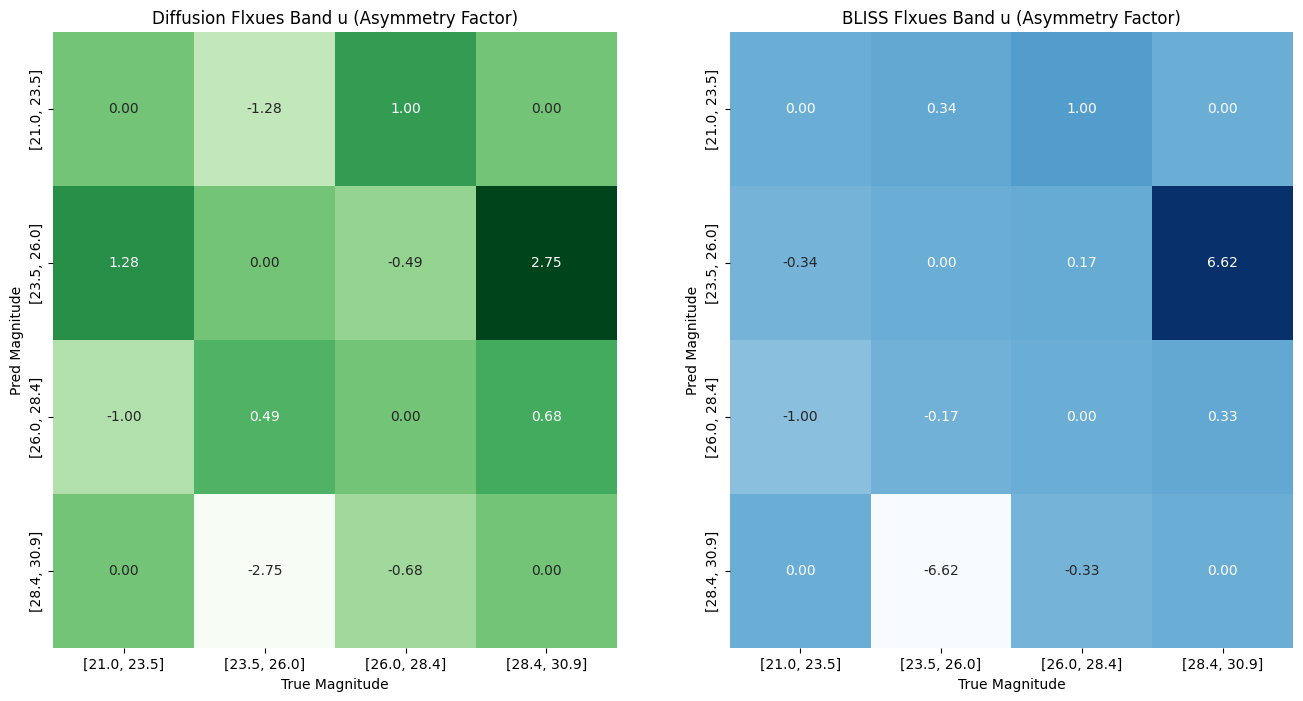

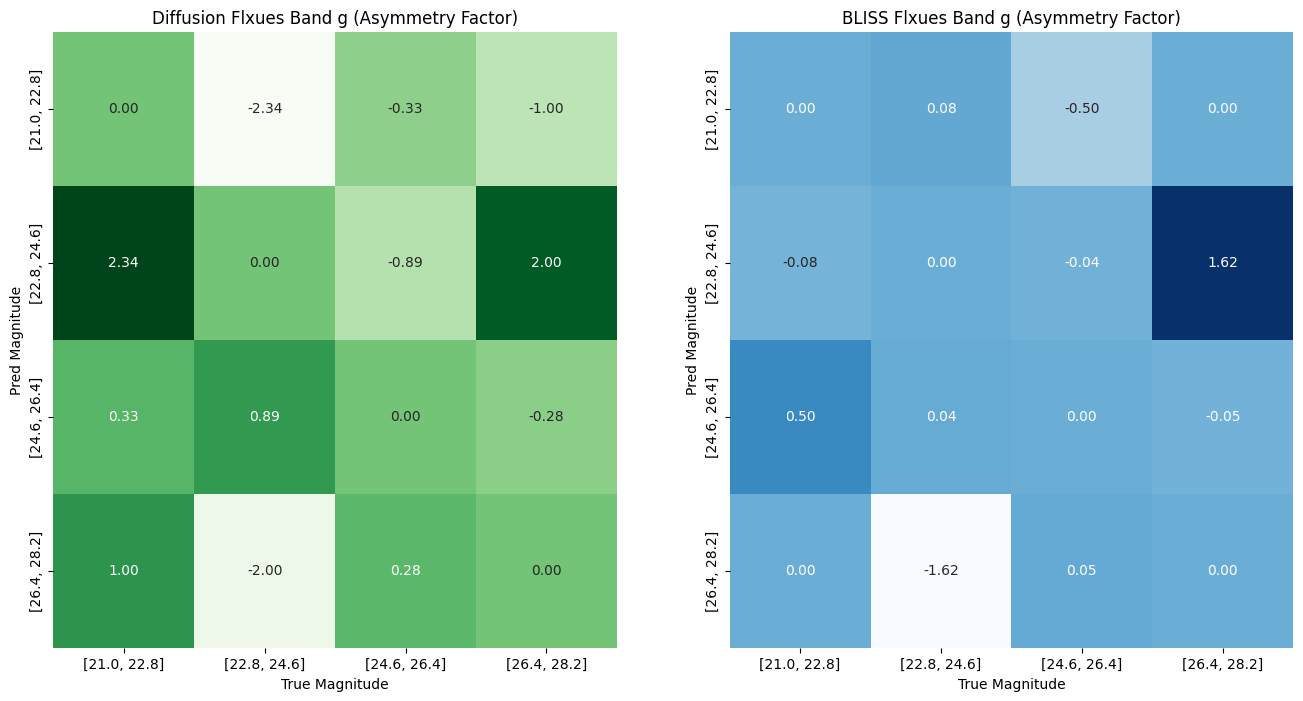

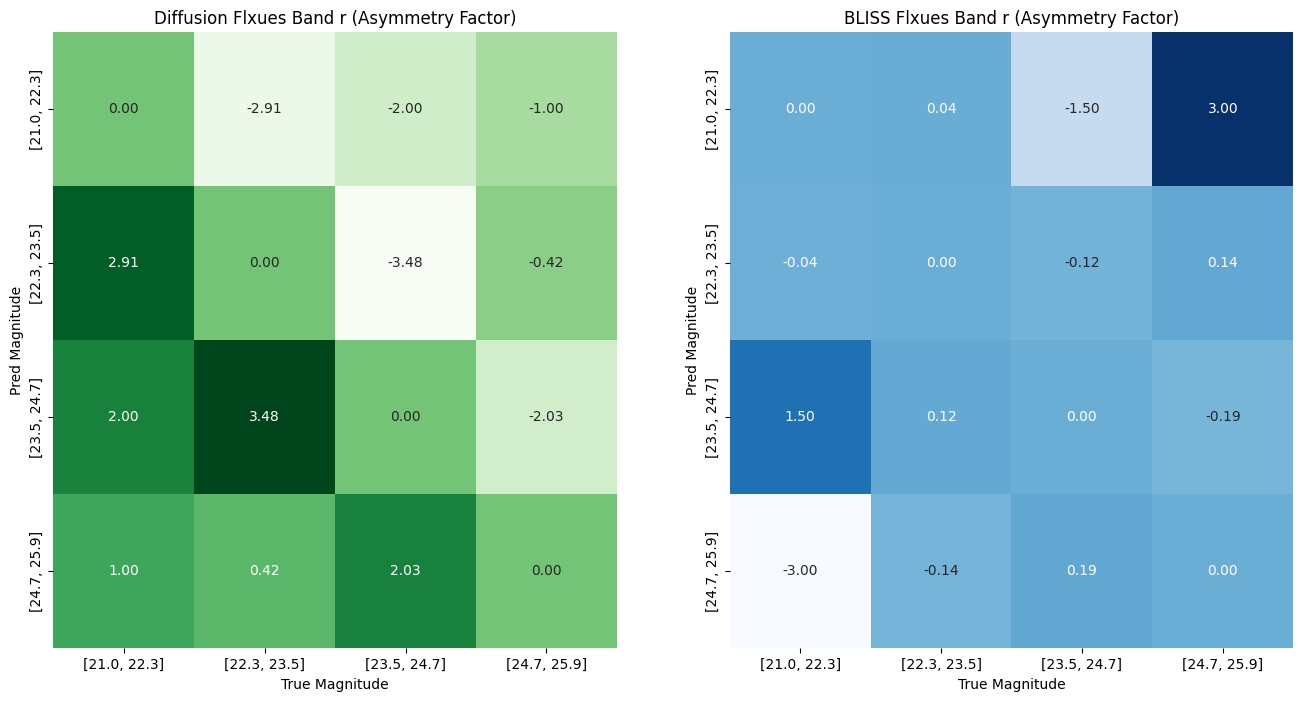

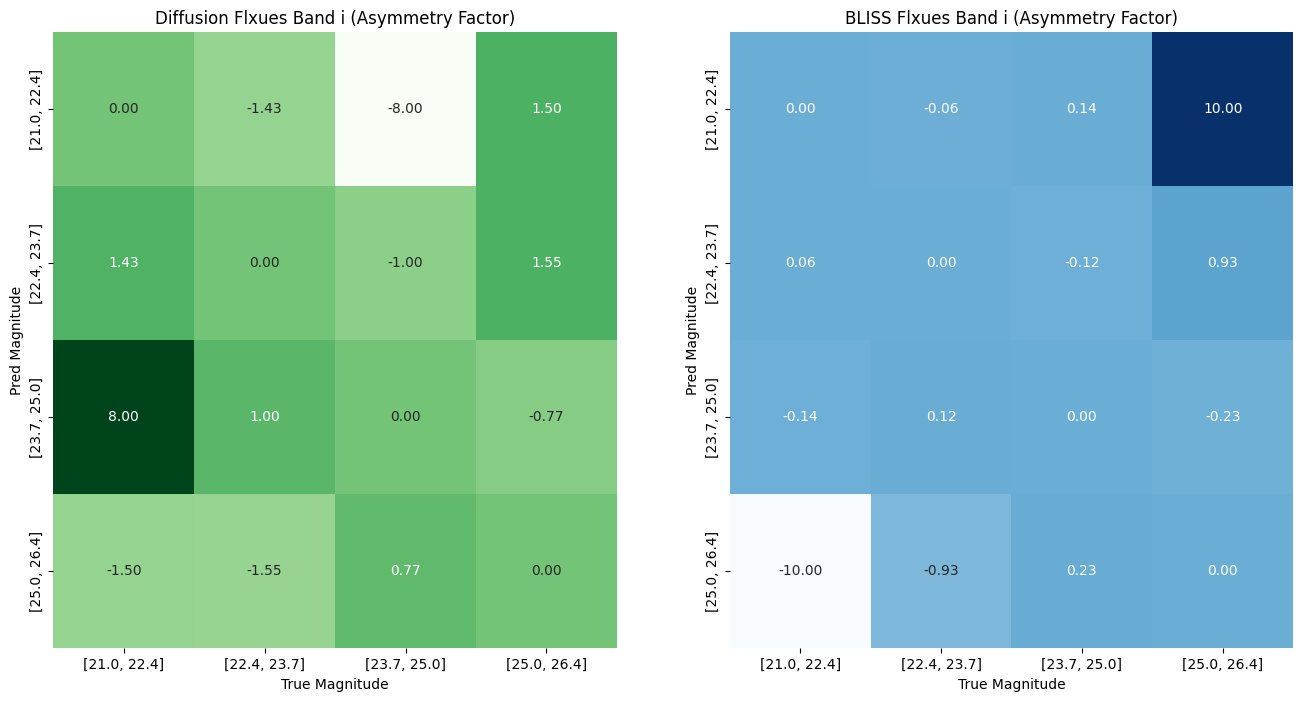

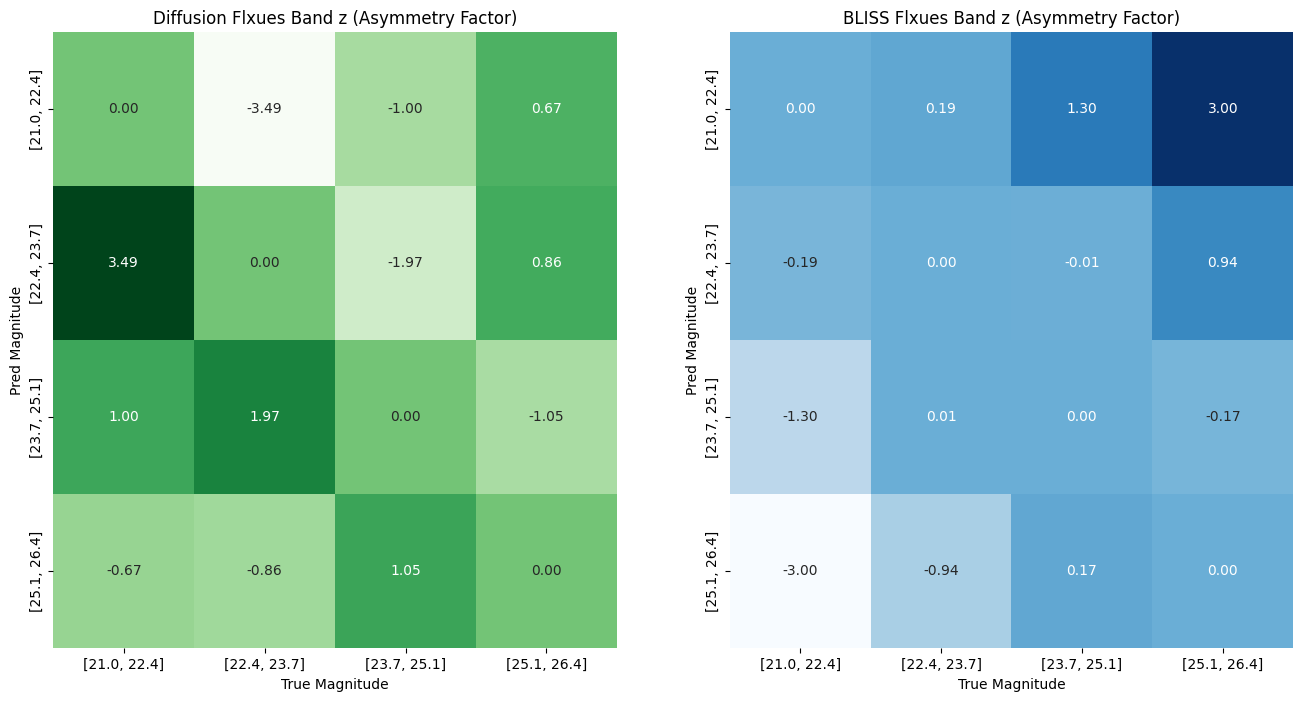

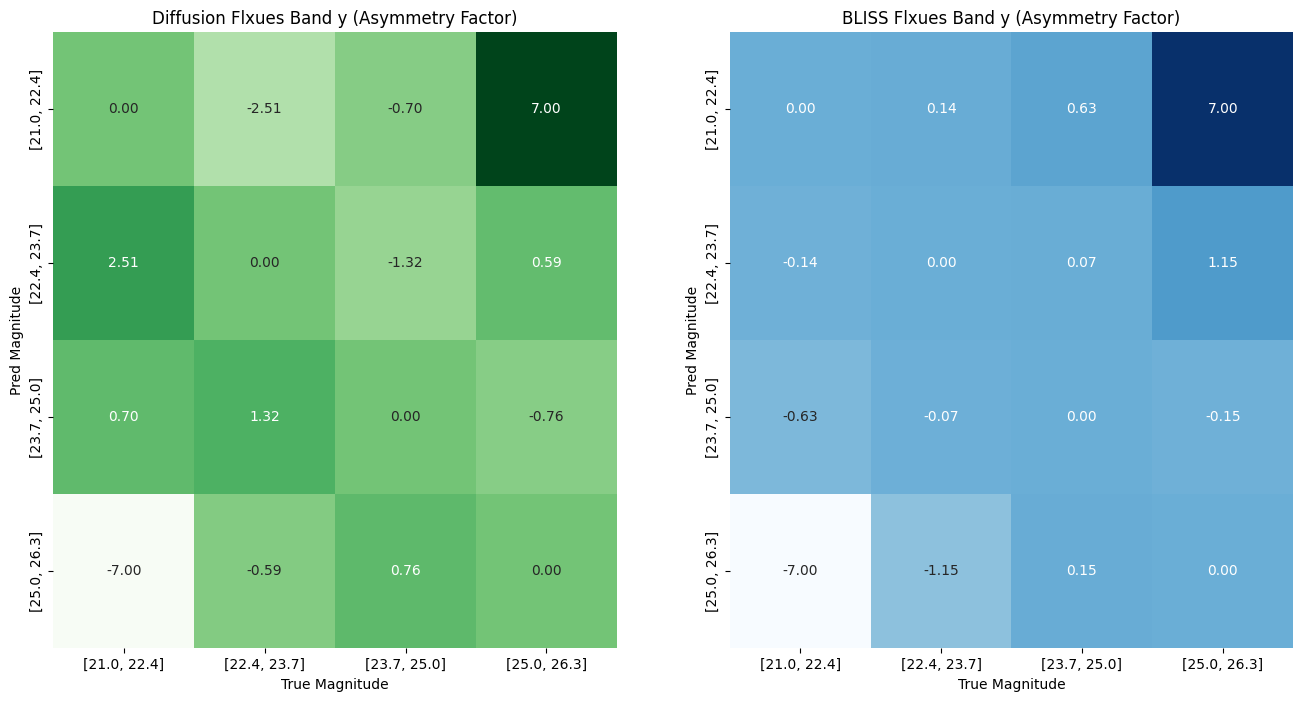

In [19]:
for band in "ugrizy":
    d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_true_m = convert_flux_to_magnitude(bliss_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)

    min_m = max(d_true_m.min().item(), b_true_m.min().item()) + 0.5
    max_m = min(d_true_m.max().item(), b_true_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_pred_m_bin_indexes = torch.bucketize(d_pred_m, bin_boundaries)
    d_true_m_bin_indexes = torch.bucketize(d_true_m, bin_boundaries)
    b_pred_m_bin_indexes = torch.bucketize(b_pred_m, bin_boundaries)
    b_true_m_bin_indexes = torch.bucketize(b_true_m, bin_boundaries)
    
    d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(d_pred_m_bin_indexes, d_true_m_bin_indexes, strict=True):
        d_cm[pred_i, true_i] += 1
    d_cm = d_cm[1:-1, 1:-1]
    d_cm = (d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)
    b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(b_pred_m_bin_indexes, b_true_m_bin_indexes, strict=True):
        b_cm[pred_i, true_i] += 1
    b_cm = b_cm[1:-1, 1:-1]
    b_cm = (b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1)

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel("True Magnitude")
    axes[0].set_ylabel("Pred Magnitude")
    axes[0].set_title(f"Diffusion Flxues Band {band} (Asymmetry Factor)")
    sns.heatmap(b_cm,
                annot=True,
                fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel("True Magnitude")
    axes[1].set_ylabel("Pred Magnitude")
    axes[1].set_title(f"BLISS Flxues Band {band} (Asymmetry Factor)")
    fig.show()

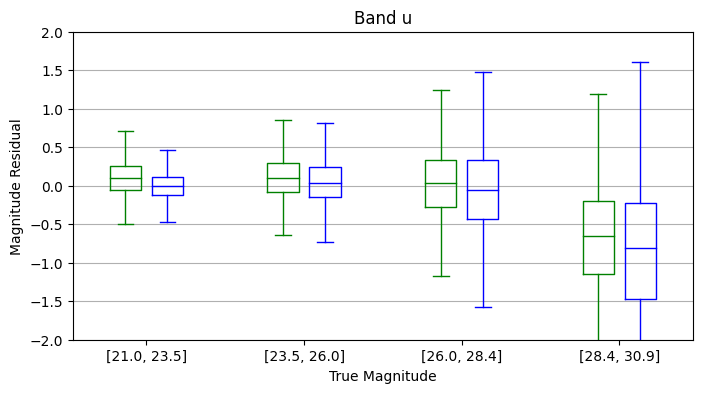

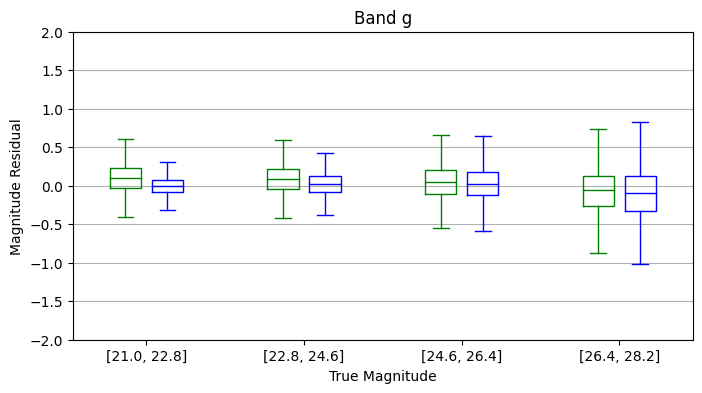

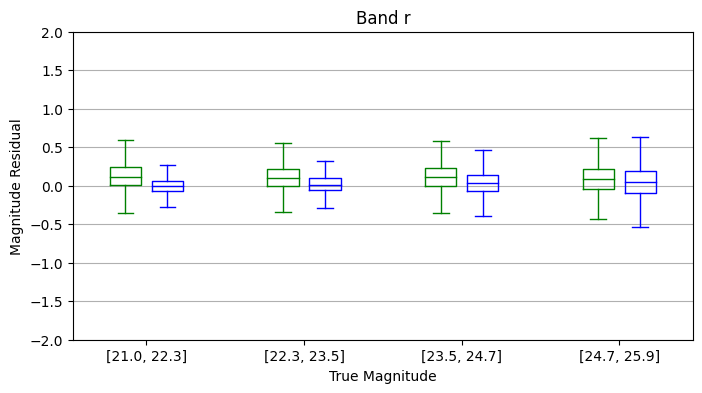

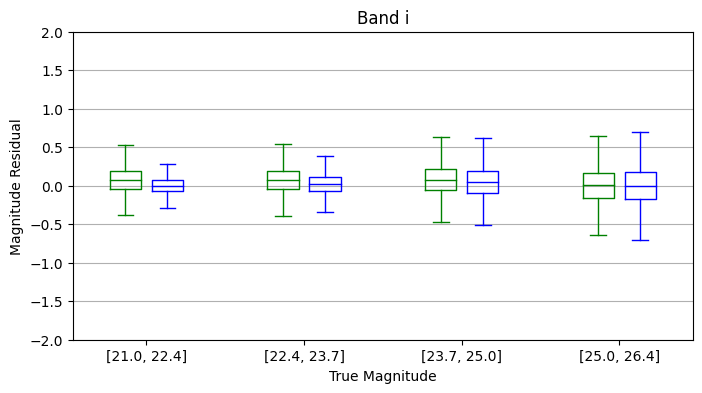

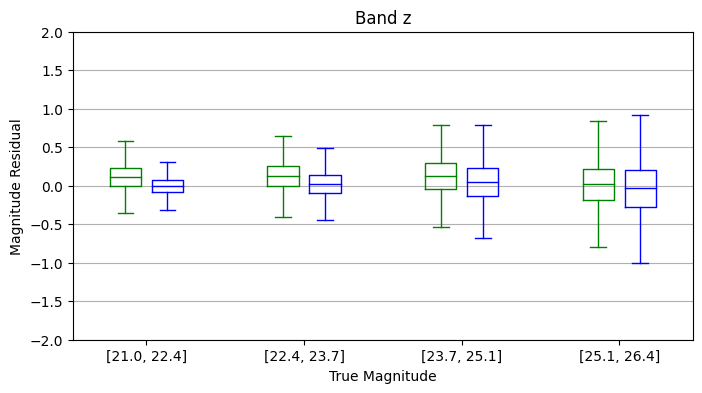

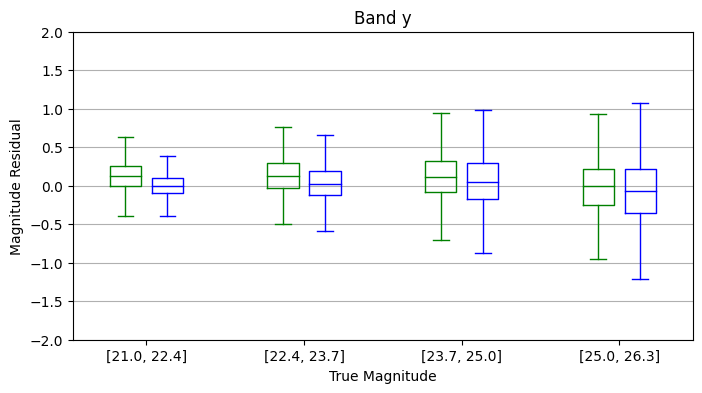

In [20]:
for band in "ugrizy":
    d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes[band].clamp(min=1.0), zero_point=3631e9)
    b_true_m = convert_flux_to_magnitude(bliss_true_fluxes[band].clamp(min=1.0), zero_point=3631e9)

    min_m = max(d_true_m.min().item(), b_true_m.min().item()) + 0.5
    max_m = min(d_true_m.max().item(), b_true_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_res_m = d_pred_m - d_true_m
    d_true_m_bin_indexes = torch.bucketize(d_true_m, bin_boundaries)
    b_res_m = b_pred_m - b_true_m
    b_true_m_bin_indexes = torch.bucketize(b_true_m, bin_boundaries)

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))

    d_res_bin_list = []
    for i in range(bin_b_num + 1):
        d_res_bin_list.append(d_res_m[d_true_m_bin_indexes == i])
    d_res_bin_list = d_res_bin_list[1:-1]
    b_res_bin_list = []
    for i in range(bin_b_num + 1):
        b_res_bin_list.append(b_res_m[b_true_m_bin_indexes == i])
    b_res_bin_list = b_res_bin_list[1:-1]

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]
    box_offset = torch.tensor(list(range(len(bin_labels)))) * 1.5
    def set_box_color(bp, color):
        plt.setp(bp["boxes"], color=color)
        plt.setp(bp["whiskers"], color=color)
        plt.setp(bp["caps"], color=color)
        plt.setp(bp["medians"], color=color)
    plt.figure(figsize=(8, 4))
    bp = plt.boxplot(d_res_bin_list, positions=box_offset, sym="", widths=0.3)
    set_box_color(bp, "green")
    bp = plt.boxplot(b_res_bin_list, positions=box_offset + 0.4, sym="", widths=0.3)
    set_box_color(bp, "blue")
    plt.ylim(-2.0, 2.0)
    plt.xlim(left=-0.5)
    plt.grid(visible=False, axis="x")
    plt.grid(visible=True, axis="y")
    plt.xticks(box_offset + 0.2, labels=bin_labels)
    plt.xlabel("True Magnitude")
    plt.ylabel("Magnitude Residual")
    plt.title(f"Band {band}")
    plt.show()

## Boundary Flux

In [21]:
def get_in_boundary_mask(locs, n_sources, boundary_width, pad_width):
    if locs.ndim == 5:
        locs = locs.squeeze(-2)
    def get_index_map(mask: torch.Tensor, dim, shift):
        assert mask.ndim == 3
        assert shift == -1 or shift == 1
        assert dim == 1 or dim == 2
        m_index = mask.nonzero()  # (z, 3)
        m_index_shift = m_index.clone()
        m_index_shift[:, dim] += shift
        return torch.stack([m_index, m_index_shift], dim=-2)  # (z, 2, 3)
    
    top_in_boundary = (locs[..., 0] > (1.0 - boundary_width)) & \
                      (locs[..., 1] > pad_width) & \
                      (locs[..., 1] < (1.0 - pad_width)) & \
                      (n_sources > 0)  # (b, h, w)
    top_in_boundary[:, -1, :] = False
    top_in_boundary_index_map = get_index_map(top_in_boundary, dim=1, shift=1)

    bottom_in_boundary = (locs[..., 0] < boundary_width) & \
                      (locs[..., 1] > pad_width) & \
                      (locs[..., 1] < (1.0 - pad_width)) & \
                      (n_sources > 0)
    bottom_in_boundary[:, 0, :] = False
    bottom_in_boundary_index_map = get_index_map(bottom_in_boundary, dim=1, shift=-1)
    
    left_in_boundary = (locs[..., 1] < boundary_width) & \
                      (locs[..., 0] > pad_width) & \
                      (locs[..., 0] < (1.0 - pad_width)) & \
                      (n_sources > 0)
    left_in_boundary[:, :, 0] = False
    left_in_boundary_index_map = get_index_map(left_in_boundary, dim=2, shift=-1)

    right_in_boundary = (locs[..., 1] > (1.0 - boundary_width)) & \
                        (locs[..., 0] > pad_width) & \
                        (locs[..., 0] < (1.0 - pad_width)) & \
                        (n_sources > 0)
    right_in_boundary[:, :, -1] = False
    right_in_boundary_index_map = get_index_map(right_in_boundary, dim=2, shift=1)
    
    return {
        "top_in_b_im": top_in_boundary_index_map,
        "bottom_in_b_im": bottom_in_boundary_index_map,
        "left_in_b_im": left_in_boundary_index_map,
        "right_in_b_im": right_in_boundary_index_map,
    }

In [22]:
d_pred_tile1_fluxes = {
    band: [] for band in "ugrizy"
}
d_pred_tile2_fluxes = {
    band: [] for band in "ugrizy"
}
d_true_tile1_fluxes = {
    band: [] for band in "ugrizy"
}
d_true_tile2_fluxes = {
    band: [] for band in "ugrizy"
}
for pred_ns, true_ns, true_locs, pred_f, true_f in zip(diffusion_result_dict["pred_n_sources_list"], 
                                                        diffusion_result_dict["target_n_sources_list"],
                                                        diffusion_result_dict["target_locs_list"],
                                                        diffusion_result_dict["pred_fluxes_list"], 
                                                        diffusion_result_dict["target_fluxes_list"],
                                                        strict=True):
    boundary_im = get_in_boundary_mask(true_locs, true_ns, boundary_width=0.02, pad_width=0.2)
    top_in_b_im = boundary_im["top_in_b_im"]  # (z, 2, 3)
    bottom_in_b_im = boundary_im["bottom_in_b_im"]
    left_in_b_im = boundary_im["left_in_b_im"]
    right_in_b_im = boundary_im["right_in_b_im"]

    def get_in_b_fluxes(in_b_im):
        for sub_im in in_b_im:
            tile1_i = sub_im[0]  # (3, )
            for band_i, band in enumerate("ugrizy"):
                d_true_tile1_fluxes[band].append(true_ns[tile1_i[0], tile1_i[1], tile1_i[2]].clamp(max=1) * \
                                                true_f[tile1_i[0], tile1_i[1], tile1_i[2], 0, band_i])
                d_pred_tile1_fluxes[band].append(pred_ns[tile1_i[0], tile1_i[1], tile1_i[2]].clamp(max=1) * \
                                                pred_f[tile1_i[0], tile1_i[1], tile1_i[2], 0, band_i])
            tile2_i = sub_im[1]  # (3, )
            for band_i, band in enumerate("ugrizy"):
                d_true_tile2_fluxes[band].append(true_ns[tile2_i[0], tile2_i[1], tile2_i[2]].clamp(max=1) * \
                                                true_f[tile2_i[0], tile2_i[1], tile2_i[2], 0, band_i])
                d_pred_tile2_fluxes[band].append(pred_ns[tile2_i[0], tile2_i[1], tile2_i[2]].clamp(max=1) * \
                                                pred_f[tile2_i[0], tile2_i[1], tile2_i[2], 0, band_i])
                
    get_in_b_fluxes(top_in_b_im)
    get_in_b_fluxes(bottom_in_b_im)
    get_in_b_fluxes(left_in_b_im)
    get_in_b_fluxes(right_in_b_im)

for k, v in d_pred_tile1_fluxes.items():
    d_pred_tile1_fluxes[k] = torch.tensor(v)
for k, v in d_pred_tile2_fluxes.items():
    d_pred_tile2_fluxes[k] = torch.tensor(v)
for k, v in d_true_tile1_fluxes.items():
    d_true_tile1_fluxes[k] = torch.tensor(v)
for k, v in d_true_tile2_fluxes.items():
    d_true_tile2_fluxes[k] = torch.tensor(v)

In [23]:
b_pred_tile1_fluxes = {
    band: [] for band in "ugrizy"
}
b_pred_tile2_fluxes = {
    band: [] for band in "ugrizy"
}
b_true_tile1_fluxes = {
    band: [] for band in "ugrizy"
}
b_true_tile2_fluxes = {
    band: [] for band in "ugrizy"
}
for pred_ns, true_ns, true_locs, pred_f, true_f in zip(bliss_result_dict["pred_n_sources_list"], 
                                                        bliss_result_dict["target_n_sources_list"],
                                                        bliss_result_dict["target_locs_list"],
                                                        bliss_result_dict["pred_fluxes_list"], 
                                                        bliss_result_dict["target_fluxes_list"],
                                                        strict=True):
    boundary_im = get_in_boundary_mask(true_locs, true_ns, boundary_width=0.02, pad_width=0.2)
    top_in_b_im = boundary_im["top_in_b_im"]  # (z, 2, 3)
    bottom_in_b_im = boundary_im["bottom_in_b_im"]
    left_in_b_im = boundary_im["left_in_b_im"]
    right_in_b_im = boundary_im["right_in_b_im"]

    def get_in_b_fluxes(in_b_im):
        for sub_im in in_b_im:
            tile1_i = sub_im[0]  # (3, )
            for band_i, band in enumerate("ugrizy"):
                b_true_tile1_fluxes[band].append(true_ns[tile1_i[0], tile1_i[1], tile1_i[2]].clamp(max=1) * \
                                                true_f[tile1_i[0], tile1_i[1], tile1_i[2], 0, band_i])
                b_pred_tile1_fluxes[band].append(pred_ns[tile1_i[0], tile1_i[1], tile1_i[2]].clamp(max=1) * \
                                                pred_f[tile1_i[0], tile1_i[1], tile1_i[2], 0, band_i])
            tile2_i = sub_im[1]  # (3, )
            for band_i, band in enumerate("ugrizy"):
                b_true_tile2_fluxes[band].append(true_ns[tile2_i[0], tile2_i[1], tile2_i[2]].clamp(max=1) * \
                                                true_f[tile2_i[0], tile2_i[1], tile2_i[2], 0, band_i])
                b_pred_tile2_fluxes[band].append(pred_ns[tile2_i[0], tile2_i[1], tile2_i[2]].clamp(max=1) * \
                                                pred_f[tile2_i[0], tile2_i[1], tile2_i[2], 0, band_i])
                
    get_in_b_fluxes(top_in_b_im)
    get_in_b_fluxes(bottom_in_b_im)
    get_in_b_fluxes(left_in_b_im)
    get_in_b_fluxes(right_in_b_im)

for k, v in b_pred_tile1_fluxes.items():
    b_pred_tile1_fluxes[k] = torch.tensor(v)
for k, v in b_pred_tile2_fluxes.items():
    b_pred_tile2_fluxes[k] = torch.tensor(v)
for k, v in b_true_tile1_fluxes.items():
    b_true_tile1_fluxes[k] = torch.tensor(v)
for k, v in b_true_tile2_fluxes.items():
    b_true_tile2_fluxes[k] = torch.tensor(v)

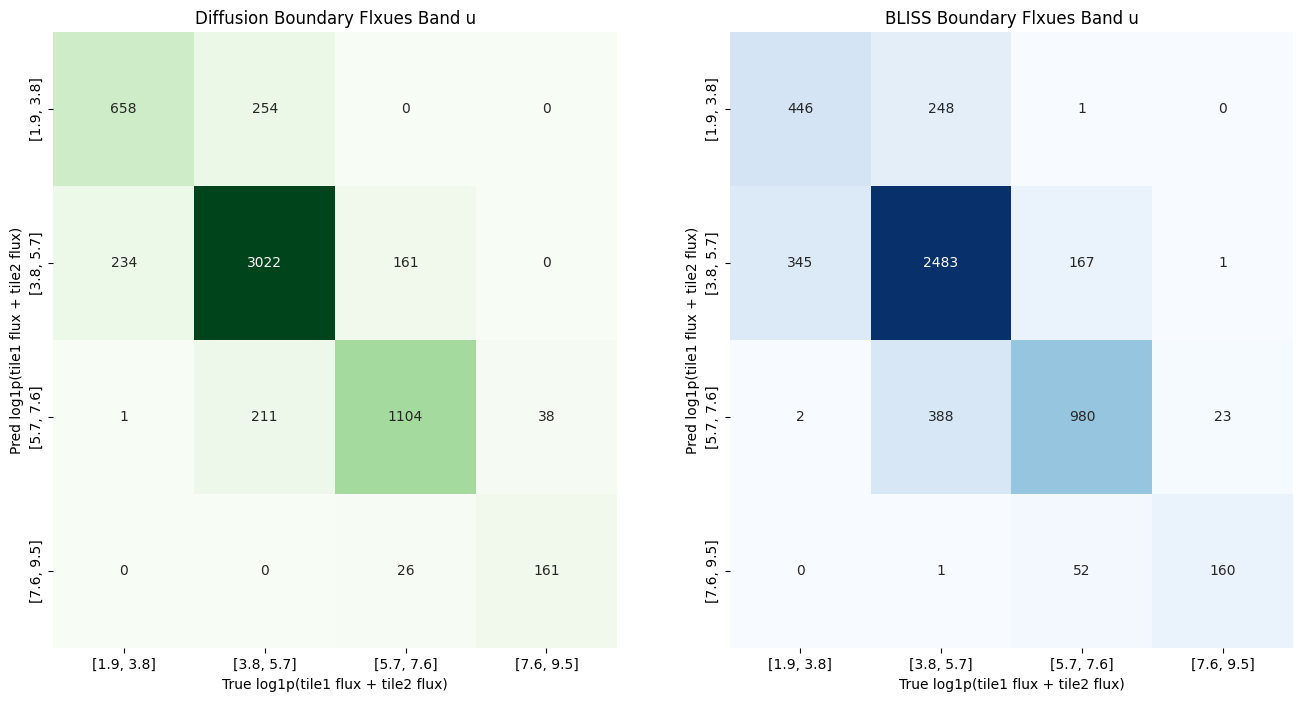

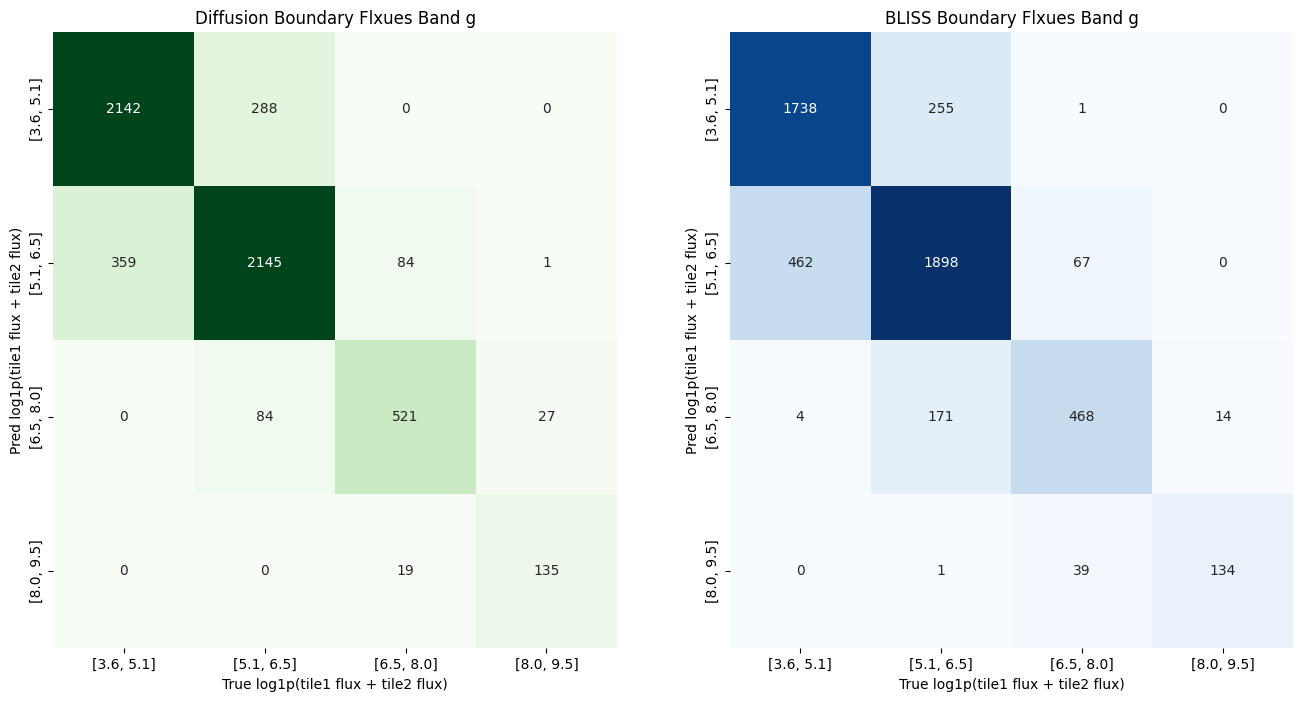

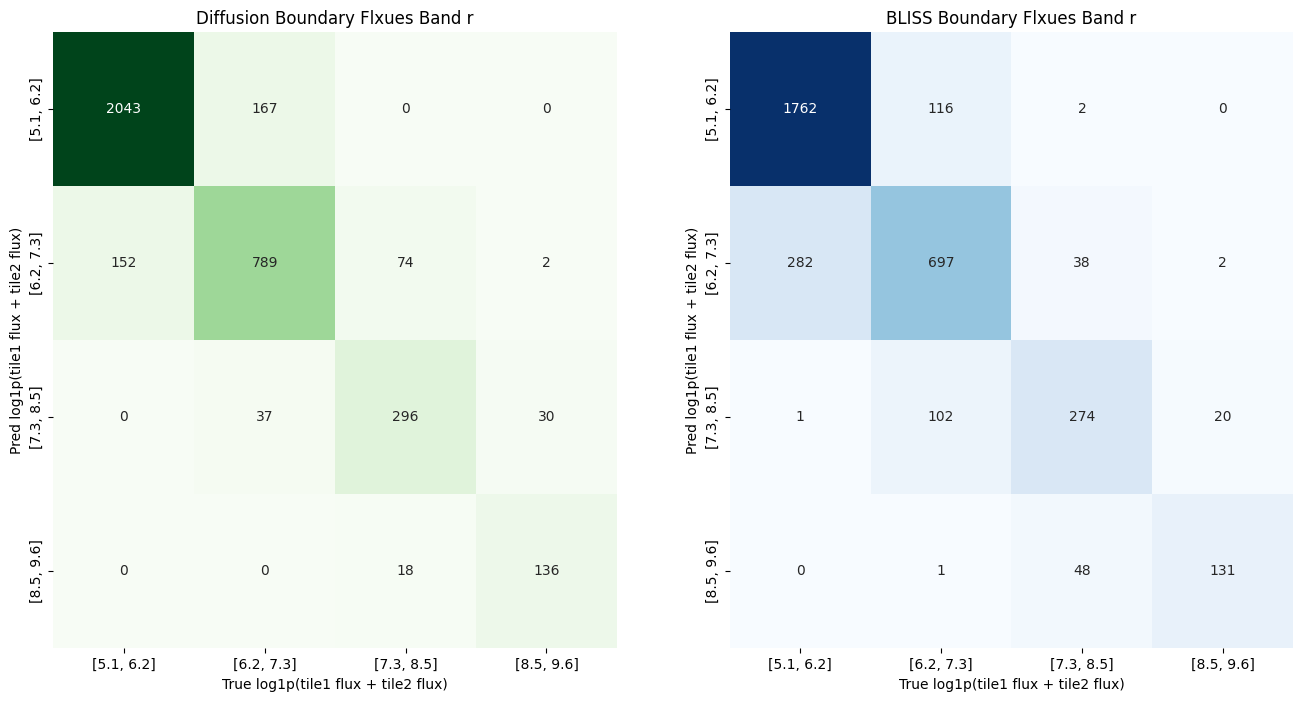

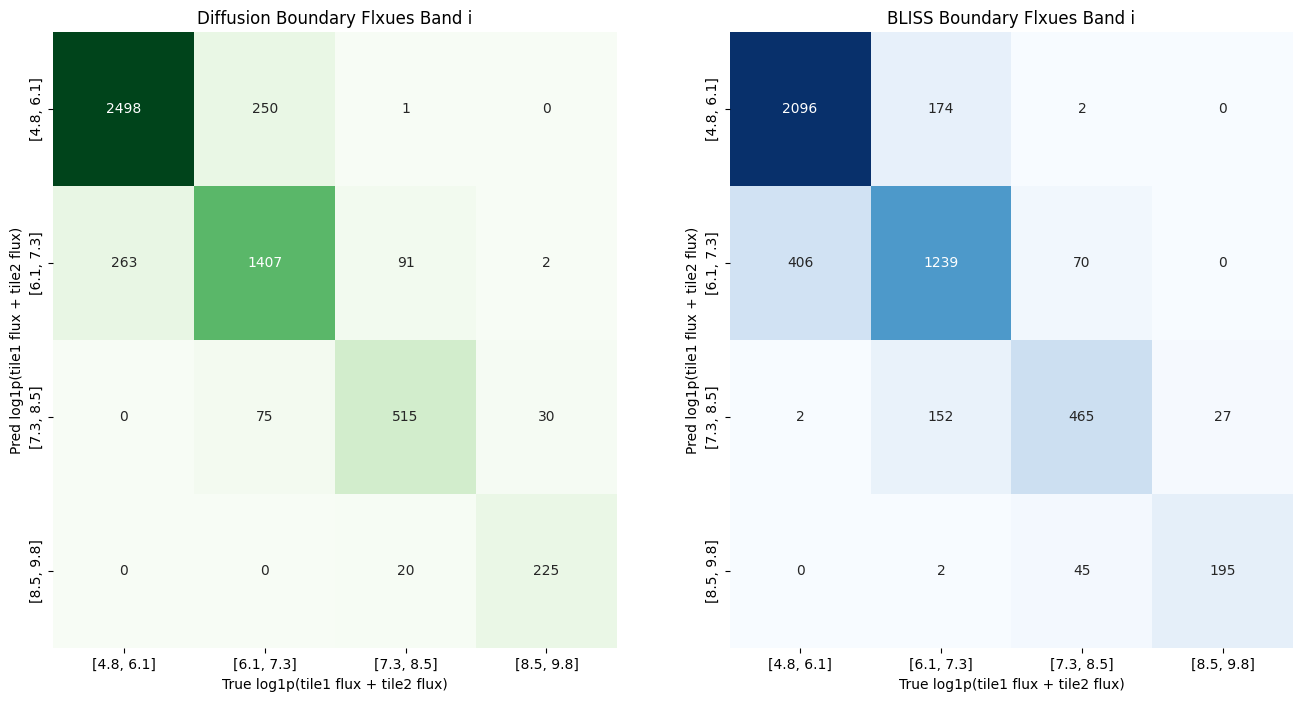

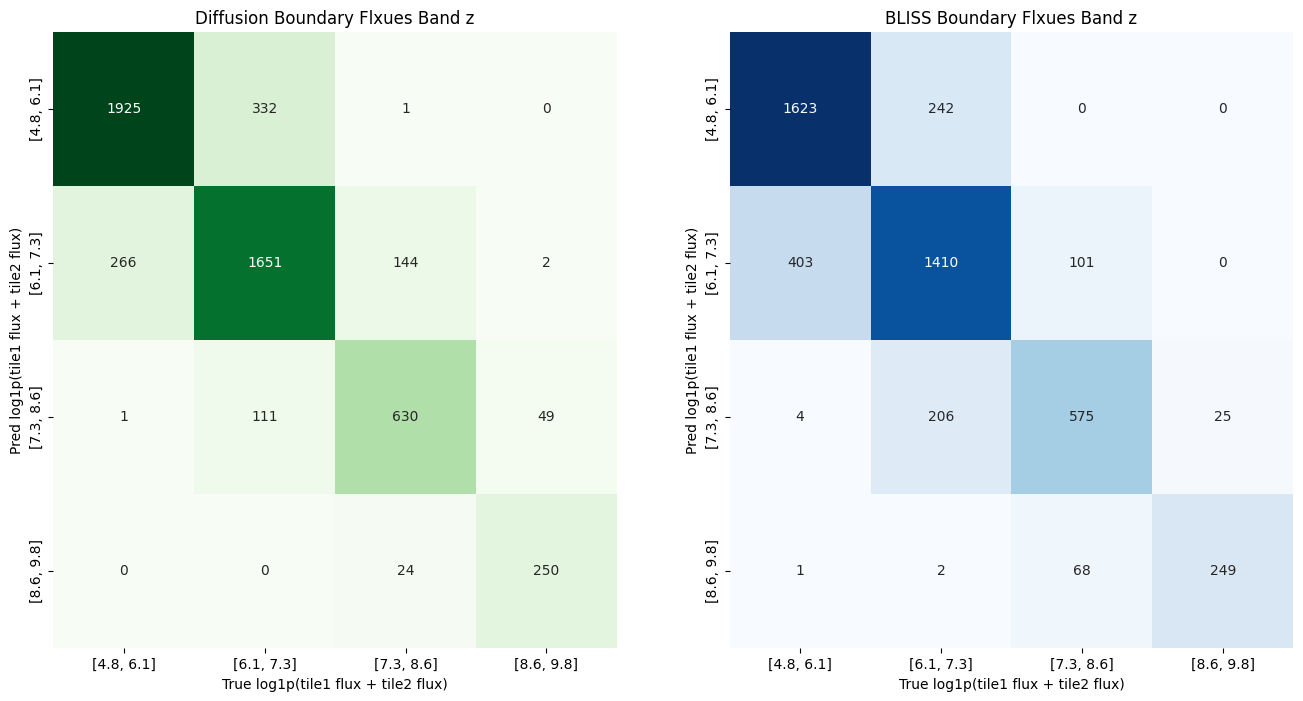

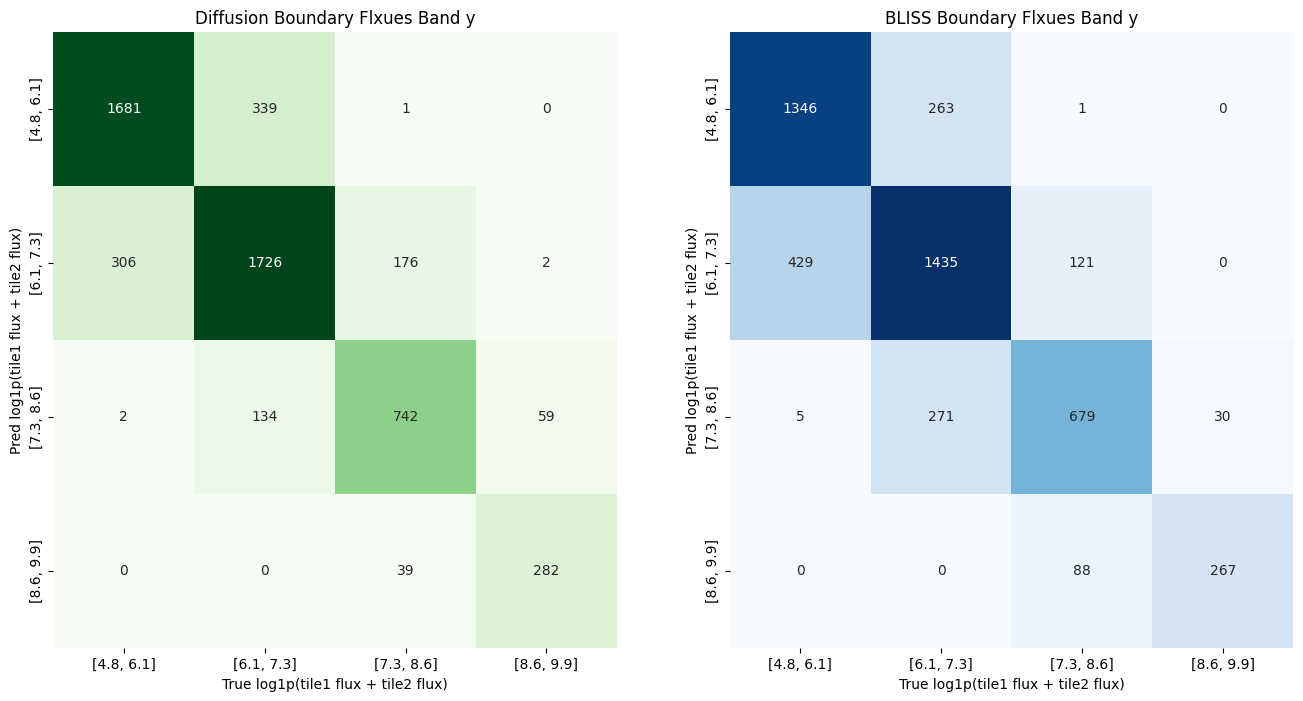

In [24]:
for band in "ugrizy":
    d_pred_tile12_m = torch.log1p(d_pred_tile1_fluxes[band] + d_pred_tile2_fluxes[band])
    d_true_tile12_m = torch.log1p(d_true_tile1_fluxes[band] + d_true_tile2_fluxes[band])
    b_pred_tile12_m = torch.log1p(b_pred_tile1_fluxes[band] + b_pred_tile2_fluxes[band])
    b_true_tile12_m = torch.log1p(b_true_tile1_fluxes[band] + b_true_tile2_fluxes[band])

    min_m = max(d_true_tile12_m.min().item(), b_true_tile12_m.min().item()) + 0.5
    max_m = min(d_true_tile12_m.max().item(), b_true_tile12_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_pred_m_bin_indexes = torch.bucketize(d_pred_tile12_m, bin_boundaries)
    d_true_m_bin_indexes = torch.bucketize(d_true_tile12_m, bin_boundaries)
    b_pred_m_bin_indexes = torch.bucketize(b_pred_tile12_m, bin_boundaries)
    b_true_m_bin_indexes = torch.bucketize(b_true_tile12_m, bin_boundaries)
    
    d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(d_pred_m_bin_indexes, d_true_m_bin_indexes, strict=True):
        d_cm[pred_i, true_i] += 1
    d_cm = d_cm[1:-1, 1:-1]
    b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(b_pred_m_bin_indexes, b_true_m_bin_indexes, strict=True):
        b_cm[pred_i, true_i] += 1
    b_cm = b_cm[1:-1, 1:-1]

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel("True log1p(tile1 flux + tile2 flux)")
    axes[0].set_ylabel("Pred log1p(tile1 flux + tile2 flux)")
    axes[0].set_title(f"Diffusion Boundary Flxues Band {band}")
    sns.heatmap(b_cm,
                annot=True,
                fmt="d", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel("True log1p(tile1 flux + tile2 flux)")
    axes[1].set_ylabel("Pred log1p(tile1 flux + tile2 flux)")
    axes[1].set_title(f"BLISS Boundary Flxues Band {band}")
    fig.show()

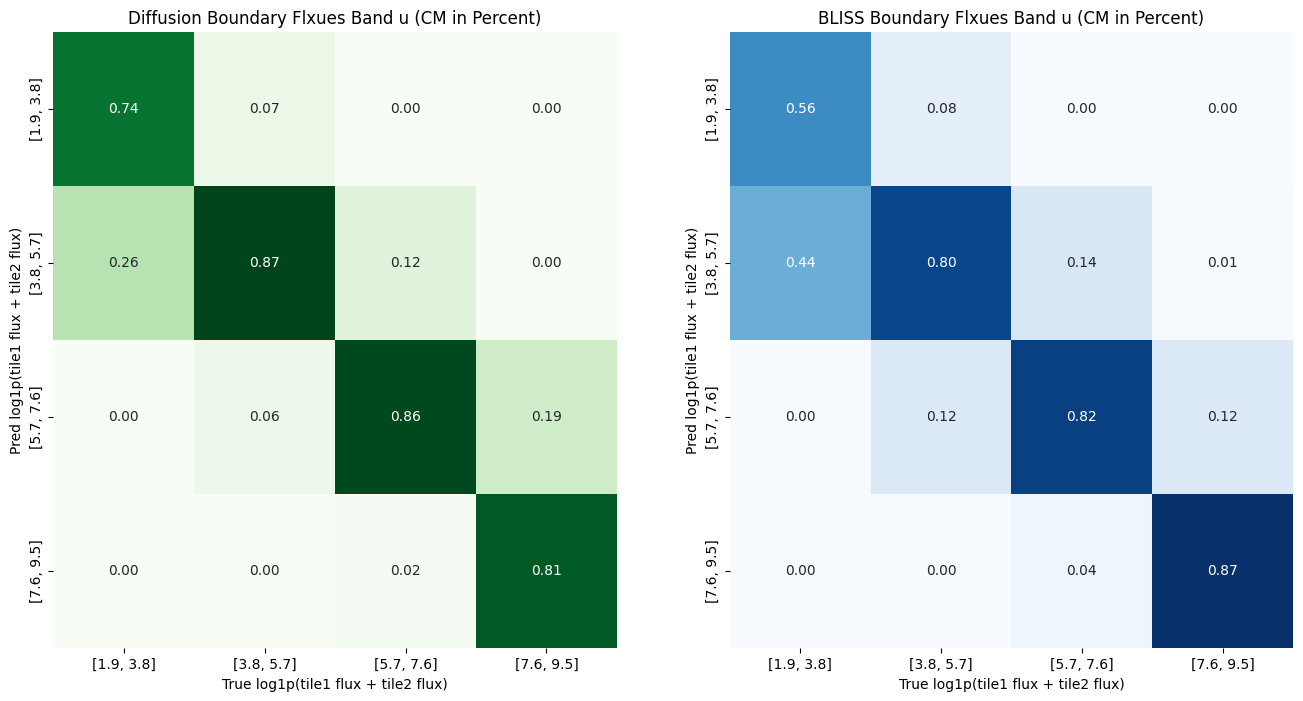

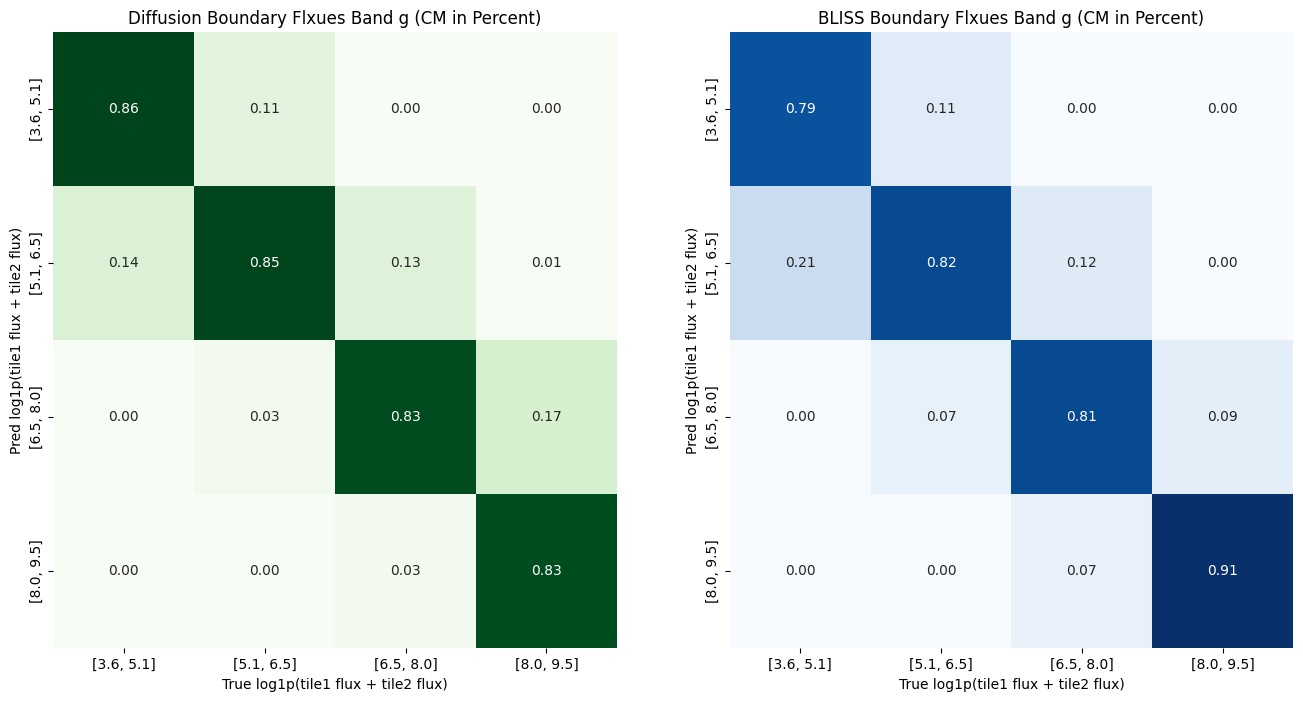

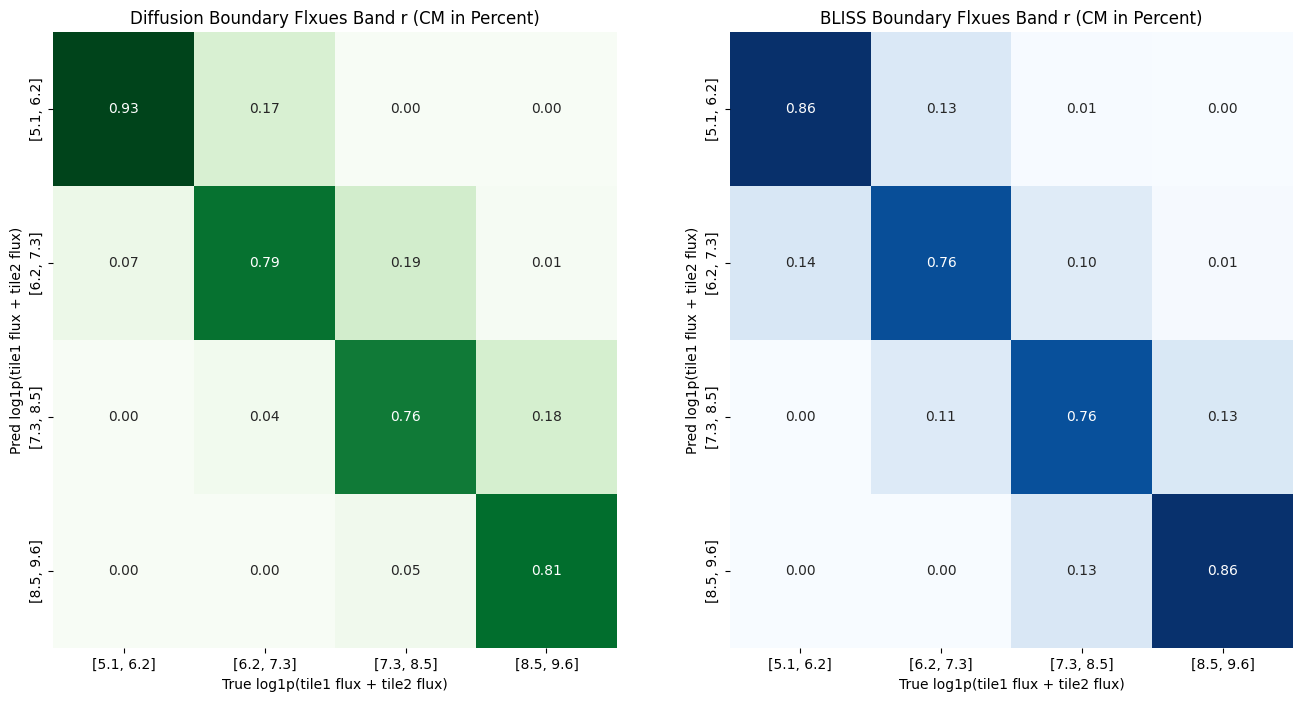

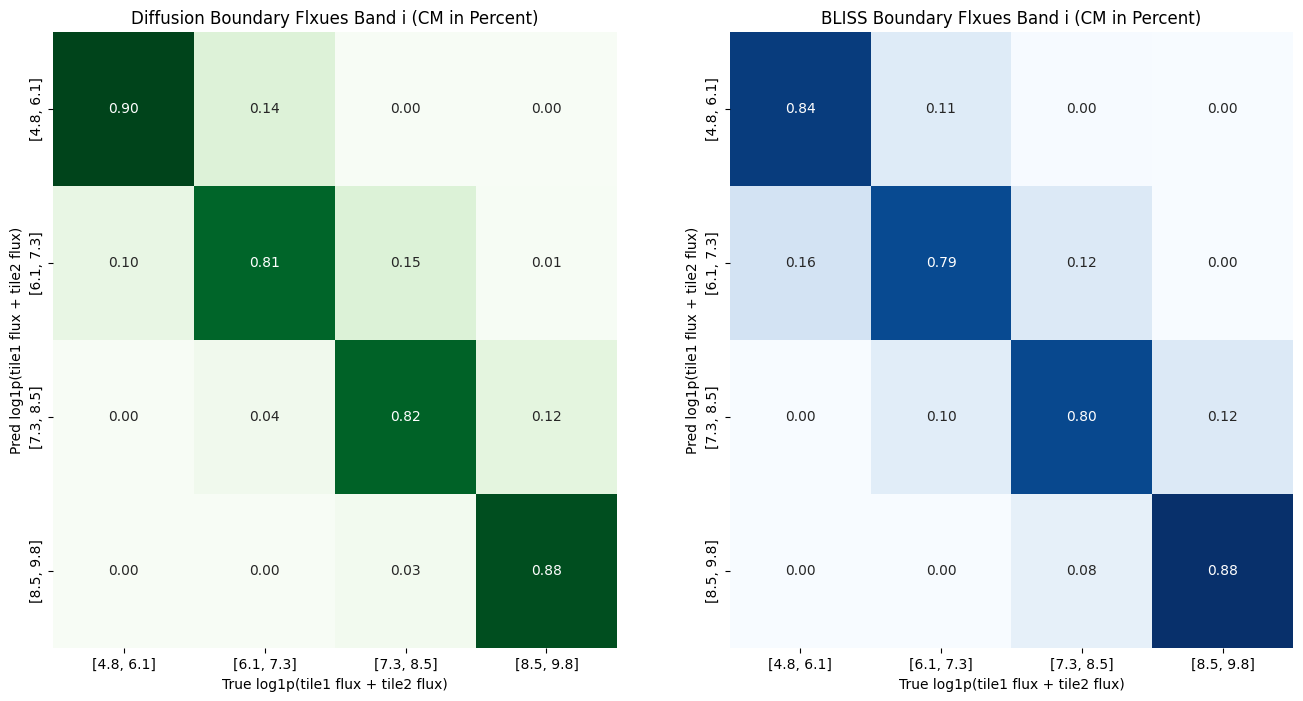

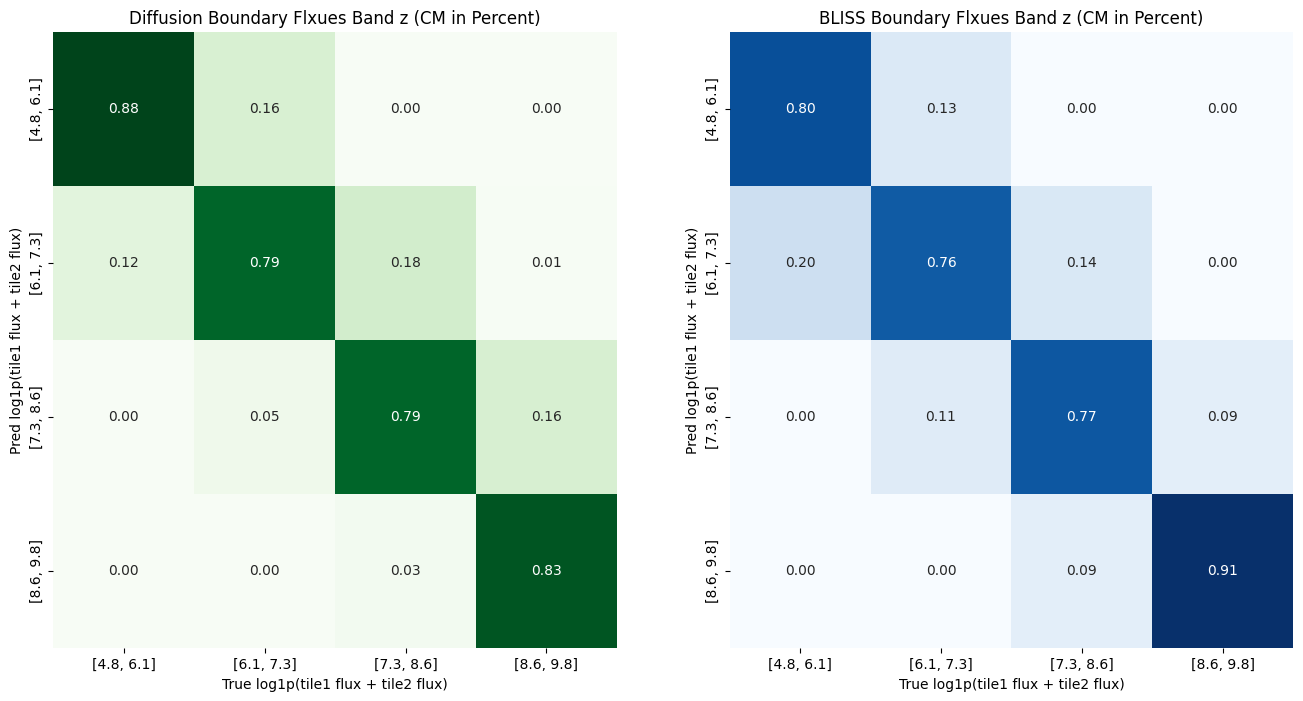

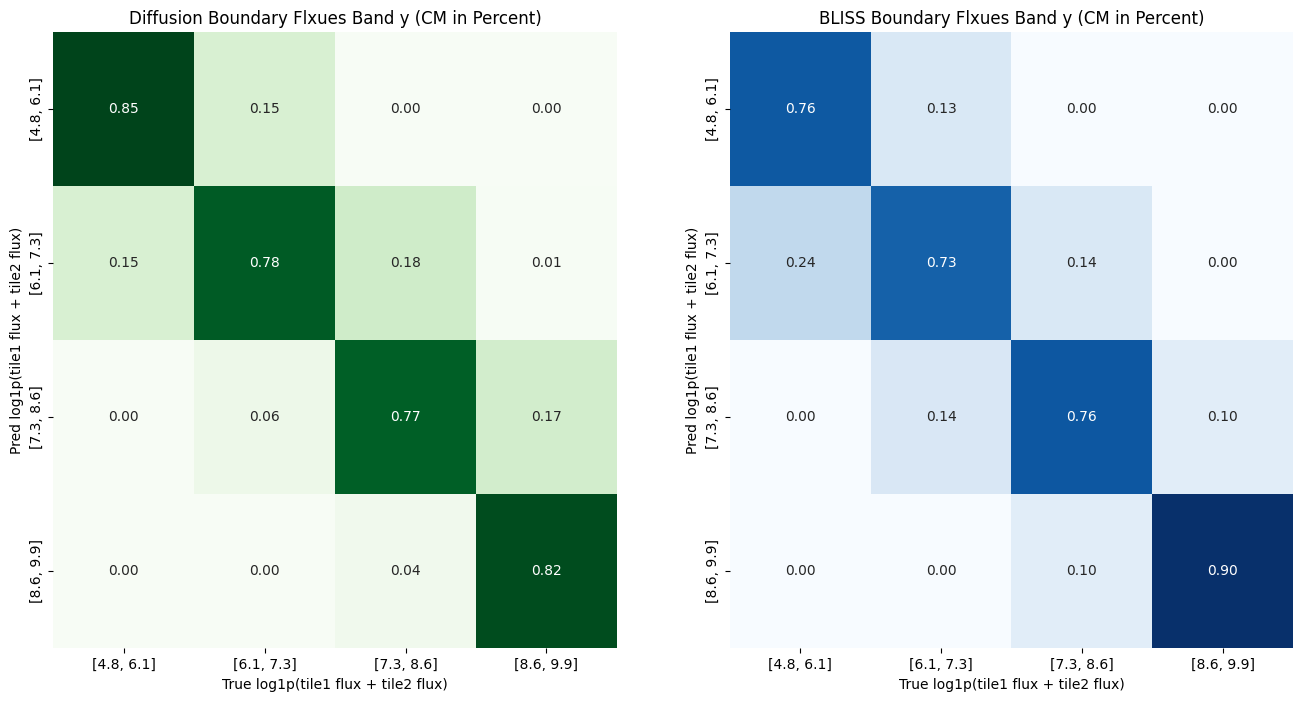

In [25]:
for band in "ugrizy":
    d_pred_tile12_m = torch.log1p(d_pred_tile1_fluxes[band] + d_pred_tile2_fluxes[band])
    d_true_tile12_m = torch.log1p(d_true_tile1_fluxes[band] + d_true_tile2_fluxes[band])
    b_pred_tile12_m = torch.log1p(b_pred_tile1_fluxes[band] + b_pred_tile2_fluxes[band])
    b_true_tile12_m = torch.log1p(b_true_tile1_fluxes[band] + b_true_tile2_fluxes[band])

    min_m = max(d_true_tile12_m.min().item(), b_true_tile12_m.min().item()) + 0.5
    max_m = min(d_true_tile12_m.max().item(), b_true_tile12_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_pred_m_bin_indexes = torch.bucketize(d_pred_tile12_m, bin_boundaries)
    d_true_m_bin_indexes = torch.bucketize(d_true_tile12_m, bin_boundaries)
    b_pred_m_bin_indexes = torch.bucketize(b_pred_tile12_m, bin_boundaries)
    b_true_m_bin_indexes = torch.bucketize(b_true_tile12_m, bin_boundaries)
    
    d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(d_pred_m_bin_indexes, d_true_m_bin_indexes, strict=True):
        d_cm[pred_i, true_i] += 1
    d_cm = d_cm[1:-1, 1:-1]
    d_cm = d_cm / torch.sum(d_cm, dim=0, keepdim=True)
    b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(b_pred_m_bin_indexes, b_true_m_bin_indexes, strict=True):
        b_cm[pred_i, true_i] += 1
    b_cm = b_cm[1:-1, 1:-1]
    b_cm = b_cm / torch.sum(b_cm, dim=0, keepdim=True)

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel("True log1p(tile1 flux + tile2 flux)")
    axes[0].set_ylabel("Pred log1p(tile1 flux + tile2 flux)")
    axes[0].set_title(f"Diffusion Boundary Flxues Band {band} (CM in Percent)")
    sns.heatmap(b_cm,
                annot=True,
                fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel("True log1p(tile1 flux + tile2 flux)")
    axes[1].set_ylabel("Pred log1p(tile1 flux + tile2 flux)")
    axes[1].set_title(f"BLISS Boundary Flxues Band {band} (CM in Percent)")
    fig.show()

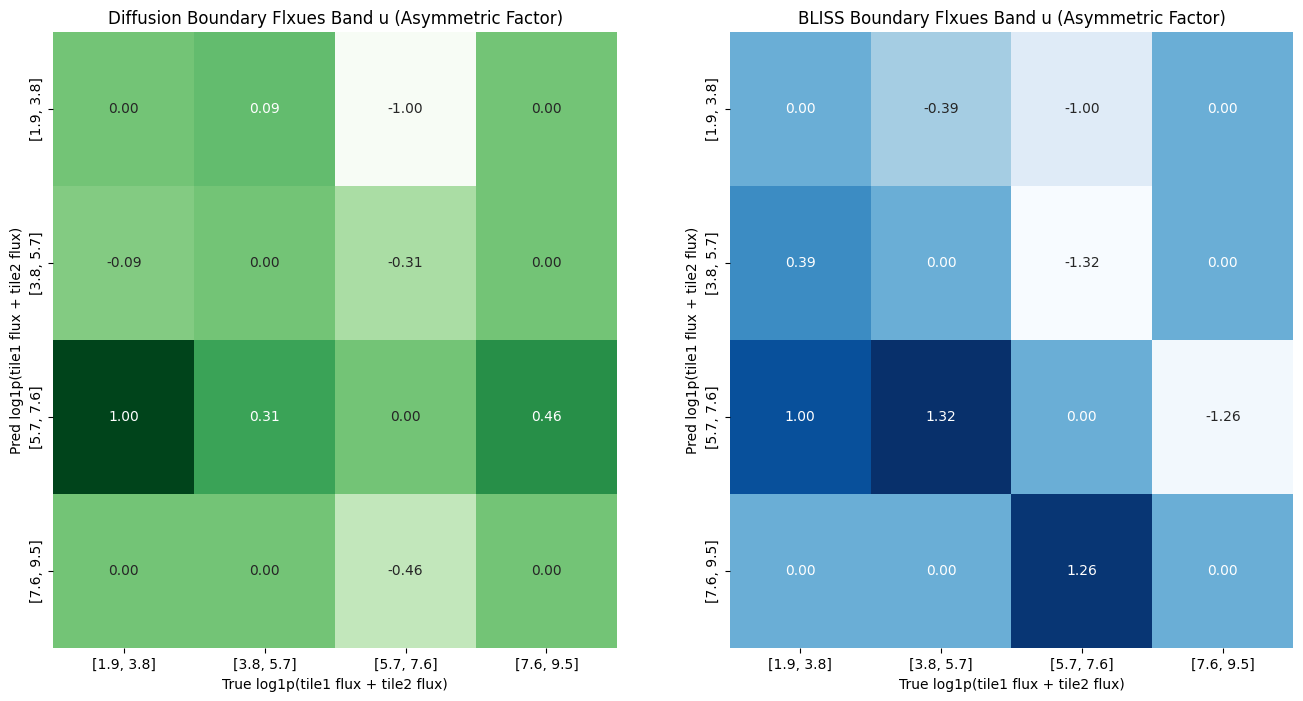

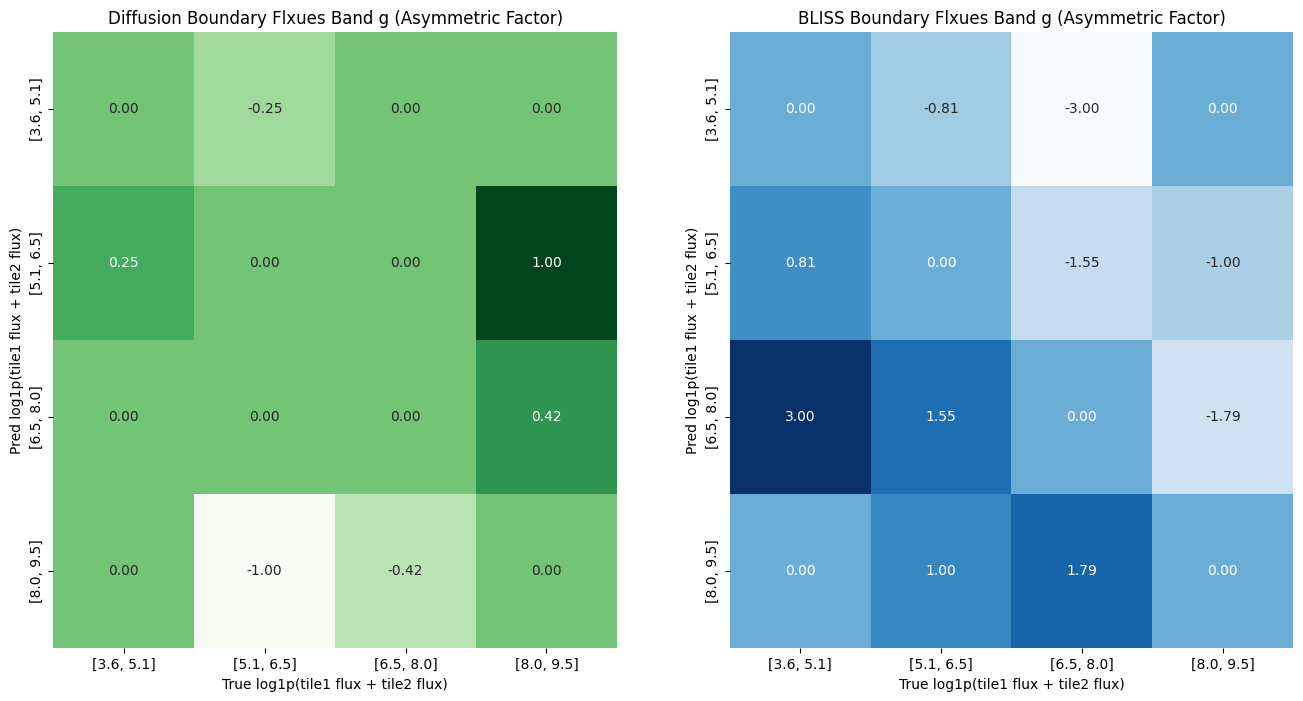

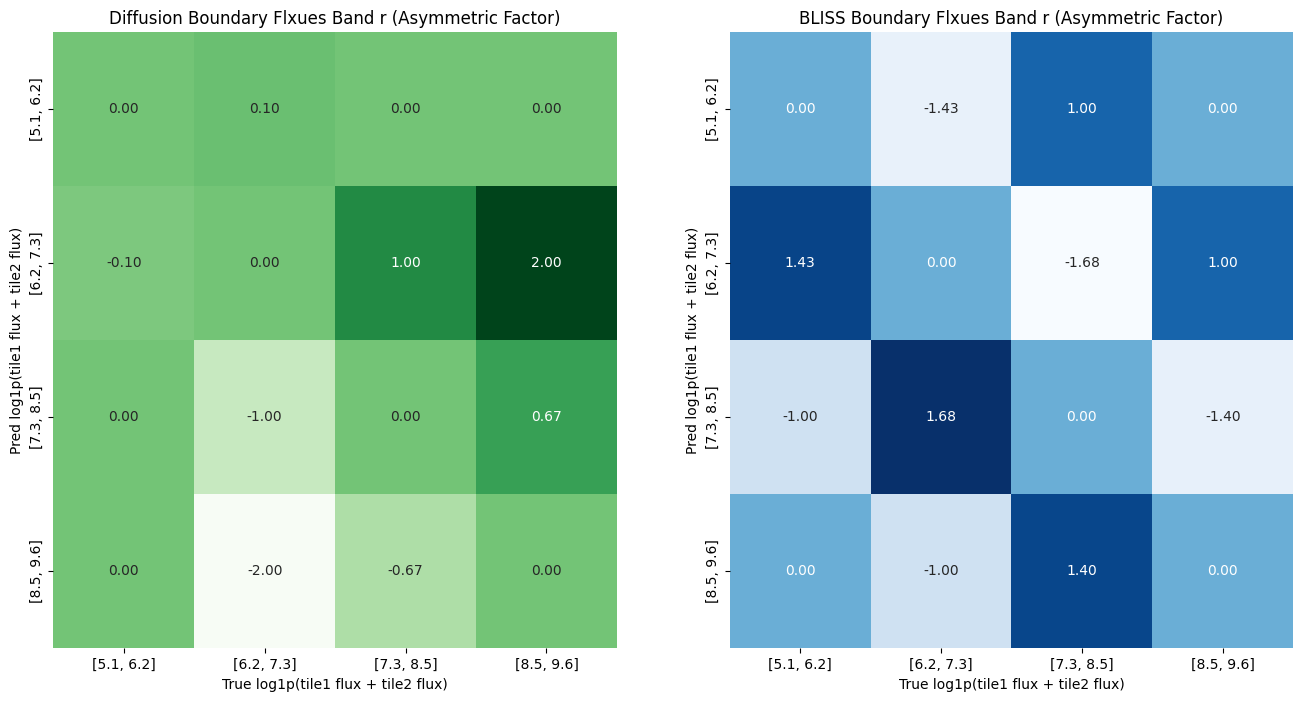

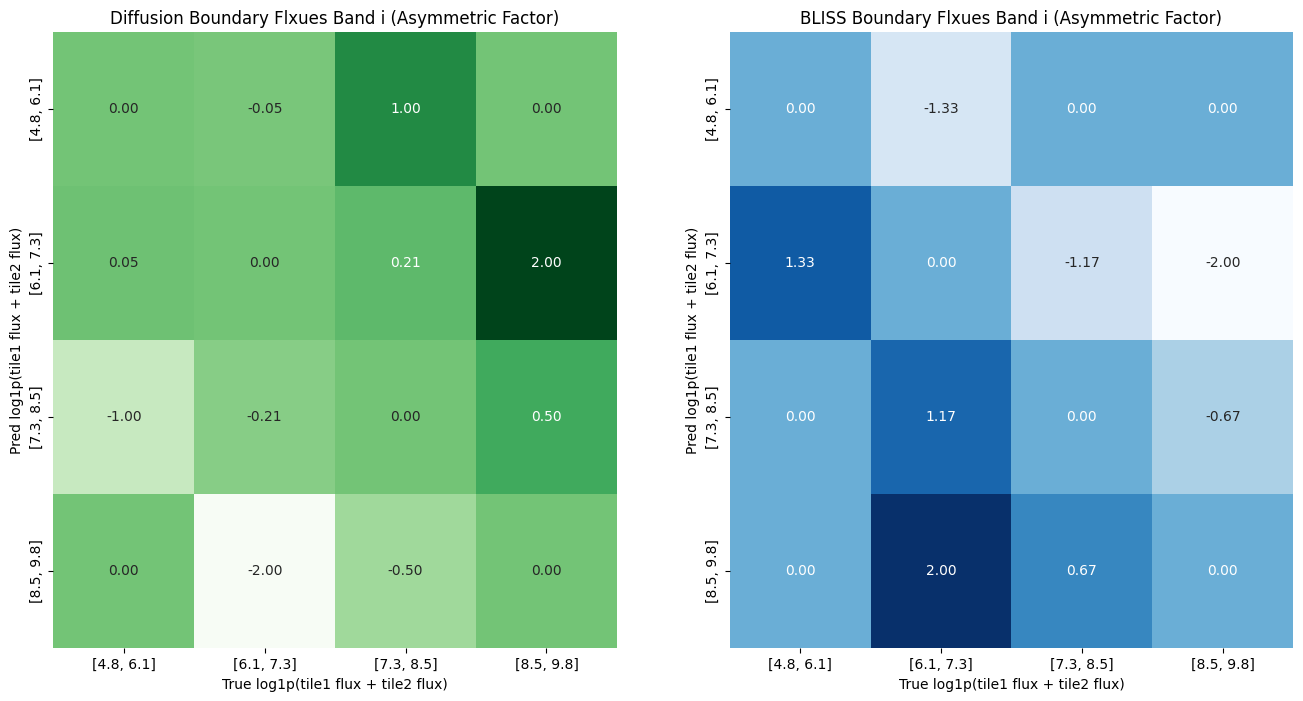

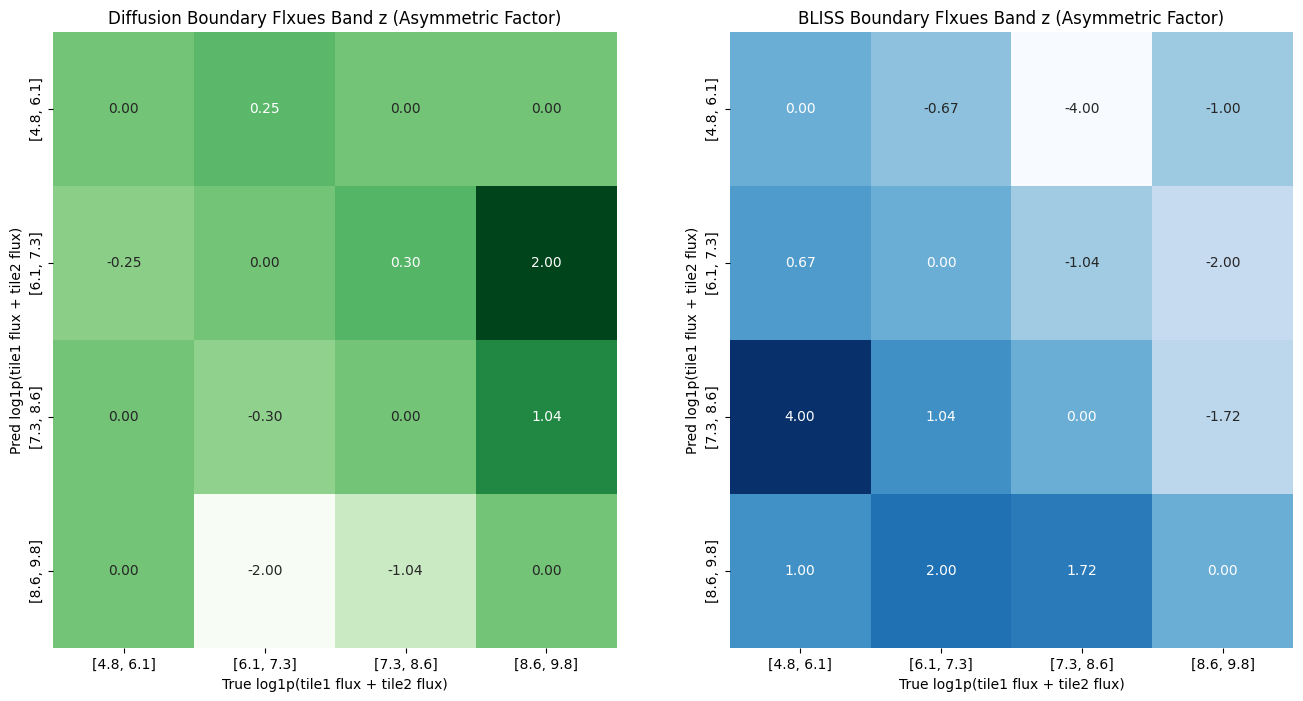

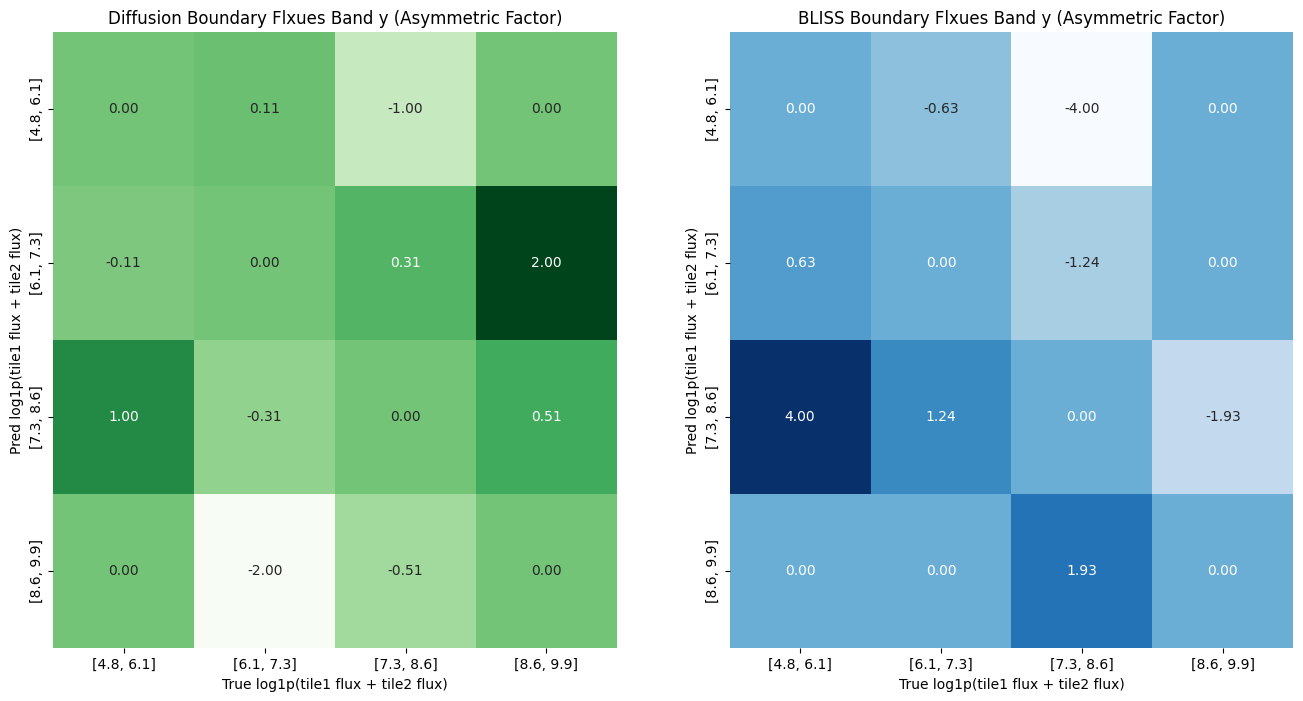

In [26]:
for band in "ugrizy":
    d_pred_tile12_m = torch.log1p(d_pred_tile1_fluxes[band] + d_pred_tile2_fluxes[band])
    d_true_tile12_m = torch.log1p(d_true_tile1_fluxes[band] + d_true_tile2_fluxes[band])
    b_pred_tile12_m = torch.log1p(b_pred_tile1_fluxes[band] + b_pred_tile2_fluxes[band])
    b_true_tile12_m = torch.log1p(b_true_tile1_fluxes[band] + b_true_tile2_fluxes[band])

    min_m = max(d_true_tile12_m.min().item(), b_true_tile12_m.min().item()) + 0.5
    max_m = min(d_true_tile12_m.max().item(), b_true_tile12_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_pred_m_bin_indexes = torch.bucketize(d_pred_tile12_m, bin_boundaries)
    d_true_m_bin_indexes = torch.bucketize(d_true_tile12_m, bin_boundaries)
    b_pred_m_bin_indexes = torch.bucketize(b_pred_tile12_m, bin_boundaries)
    b_true_m_bin_indexes = torch.bucketize(b_true_tile12_m, bin_boundaries)
    
    d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(d_pred_m_bin_indexes, d_true_m_bin_indexes, strict=True):
        d_cm[pred_i, true_i] += 1
    d_cm = d_cm[1:-1, 1:-1]
    d_cm = (d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)
    b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
    for pred_i, true_i in zip(b_pred_m_bin_indexes, b_true_m_bin_indexes, strict=True):
        b_cm[pred_i, true_i] += 1
    b_cm = b_cm[1:-1, 1:-1]
    b_cm = (b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1)

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel("True log1p(tile1 flux + tile2 flux)")
    axes[0].set_ylabel("Pred log1p(tile1 flux + tile2 flux)")
    axes[0].set_title(f"Diffusion Boundary Flxues Band {band} (Asymmetric Factor)")
    sns.heatmap(b_cm,
                annot=True,
                fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel("True log1p(tile1 flux + tile2 flux)")
    axes[1].set_ylabel("Pred log1p(tile1 flux + tile2 flux)")
    axes[1].set_title(f"BLISS Boundary Flxues Band {band} (Asymmetric Factor)")
    fig.show()

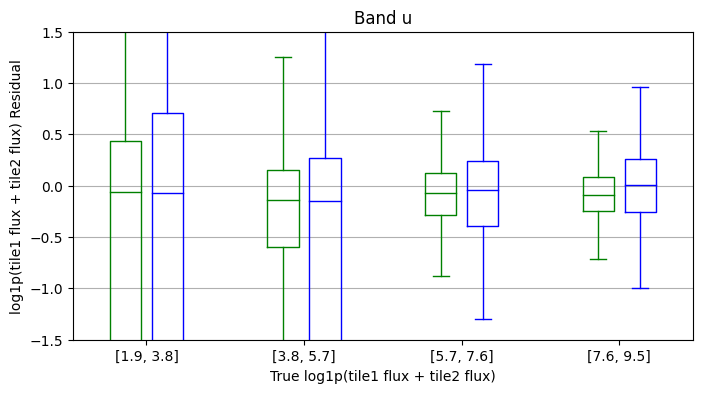

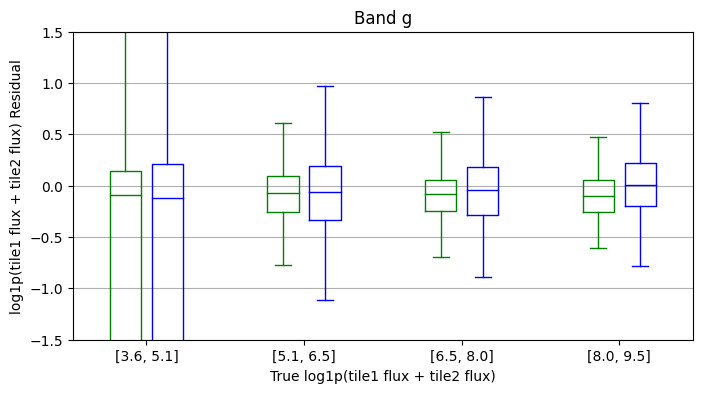

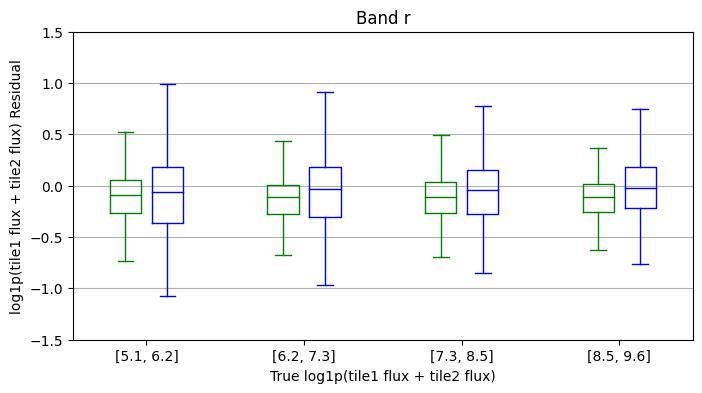

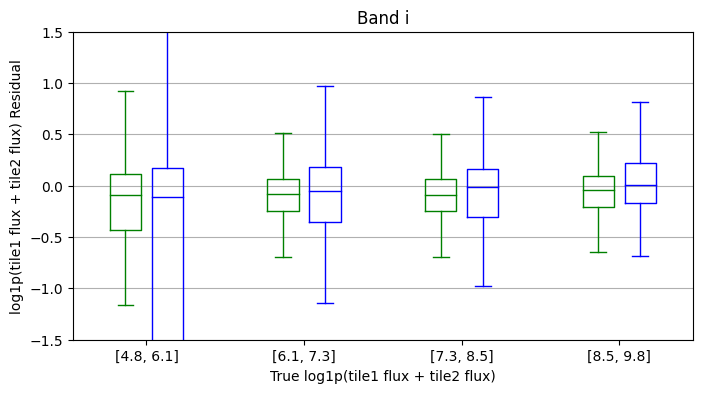

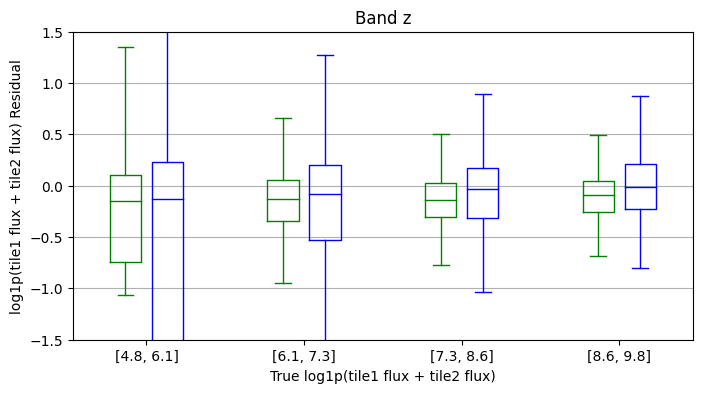

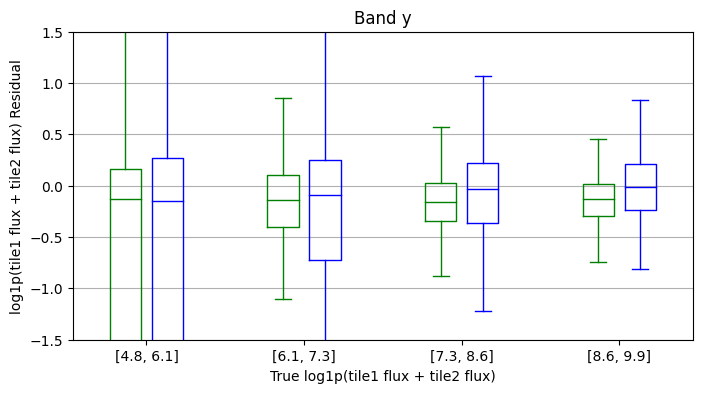

In [27]:
for band in "ugrizy":
    d_pred_tile12_m = torch.log1p(d_pred_tile1_fluxes[band] + d_pred_tile2_fluxes[band])
    d_true_tile12_m = torch.log1p(d_true_tile1_fluxes[band] + d_true_tile2_fluxes[band])
    b_pred_tile12_m = torch.log1p(b_pred_tile1_fluxes[band] + b_pred_tile2_fluxes[band])
    b_true_tile12_m = torch.log1p(b_true_tile1_fluxes[band] + b_true_tile2_fluxes[band])

    min_m = max(d_true_tile12_m.min().item(), b_true_tile12_m.min().item()) + 0.5
    max_m = min(d_true_tile12_m.max().item(), b_true_tile12_m.max().item()) - 0.5

    bin_b_num = 5
    bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    d_tile12_m_res = d_pred_tile12_m - d_true_tile12_m
    d_true_m_bin_indexes = torch.bucketize(d_true_tile12_m, bin_boundaries)
    b_tile12_m_res = b_pred_tile12_m - b_true_tile12_m
    b_true_m_bin_indexes = torch.bucketize(b_true_tile12_m, bin_boundaries)

    d_res_bin_list = []
    for i in range(bin_b_num + 1):
        d_res_bin_list.append(d_tile12_m_res[d_true_m_bin_indexes == i])
    d_res_bin_list = d_res_bin_list[1:-1]
    b_res_bin_list = []
    for i in range(bin_b_num + 1):
        b_res_bin_list.append(b_tile12_m_res[b_true_m_bin_indexes == i])
    b_res_bin_list = b_res_bin_list[1:-1]

    bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]
    box_offset = torch.tensor(list(range(len(bin_labels)))) * 1.5
    def set_box_color(bp, color):
        plt.setp(bp["boxes"], color=color)
        plt.setp(bp["whiskers"], color=color)
        plt.setp(bp["caps"], color=color)
        plt.setp(bp["medians"], color=color)
    plt.figure(figsize=(8, 4))
    bp = plt.boxplot(d_res_bin_list, positions=box_offset, sym="", widths=0.3)
    set_box_color(bp, "green")
    bp = plt.boxplot(b_res_bin_list, positions=box_offset + 0.4, sym="", widths=0.3)
    set_box_color(bp, "blue")
    plt.ylim(-1.5, 1.5)
    plt.xlim(left=-0.5)
    plt.grid(visible=False, axis="x")
    plt.grid(visible=True, axis="y")
    plt.xticks(box_offset + 0.2, labels=bin_labels)
    plt.xlabel("True log1p(tile1 flux + tile2 flux)")
    plt.ylabel("log1p(tile1 flux + tile2 flux) Residual")
    plt.title(f"Band {band}")
    plt.show()